# Predictions on credits.
The notebook provides analysis of credit variables based on dataset of clients.

The steps of the workflow:
1. Problem definiton.
2. Data preparation.
3. Data analysis and feature importance.
4. Modeling 1 (dropping NaN values).
5. Come up with an algorithm to replace NaN values with some category.
6. Modeling 2 (replacing NaN values).
7. Compare Modeling 1 and Modeling 2.


**NOTE**: train_data will be splitted into train and validation sets, only final model's performance is going to be tested on `test_data`.


## 1. Problem definition.

> The purposes of the task are:
* to predict whether a client will overdue a received credit or not.
* to compare different models based on the dataset they are trained on.
* to explain the results.


## 2. Data preparation.

In [1]:
# Main libraries
import sklearn
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Process
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

# Saving in binary
import pickle

In [2]:
train_data = pd.read_csv('train.csv', index_col='order_id')
train_data

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
order_id,,,,,,,,,,,,,,,,,,,,,
5498546,0.0,0,40364,0,0.0,3000,560,0.0,0.00,0,...,0.0,0,0.00,0,0,3,50000,46,NaN,0
5498604,1500.0,0,23456,0,0.0,0,9999,0.0,0.00,0,...,0.0,0,0.00,0,0,3,35000,17,NaN,0
5498609,0.1,0,17999,3,0.0,9999,9999,0.1,9999.00,0,...,0.0,0,0.00,0,2,3,35000,58,NaN,0
5498645,5000.0,0,313247,0,0.0,0,9999,0.0,0.00,0,...,0.0,0,4923.97,0,0,5,35000,4,NaN,0
5498647,0.0,0,0,1,0.0,0,9999,0.0,0.00,0,...,0.0,0,0.00,0,0,5,35000,34,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697173,0.0,0,0,3,0.0,0,733,0.0,0.00,0,...,0.0,0,0.00,0,0,3,35000,60,NaN,0
6697212,0.0,1,25400,3,9500.0,17750,49,0.0,0.00,25400,...,9500.0,5,0.00,1,0,5,20000,7,NaN,0
6697215,1000.0,0,64490,2,0.0,1000,414,0.0,0.00,0,...,0.0,0,0.00,0,0,4,35000,94,NaN,0


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23116 entries, 5498546 to 6697265
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cred_sum_cc_all               23116 non-null  float64
 1   mfo_inqs_count_month          23116 non-null  int64  
 2   all_closed_creds_sum_all      23116 non-null  int64  
 3   bank_inqs_count_quarter       23116 non-null  int64  
 4   cred_max_overdue_max_ly       23116 non-null  float64
 5   all_active_creds_sum_all      23116 non-null  int64  
 6   mfo_last_days_all             23116 non-null  int64  
 7   cred_sum_cc_ly                23116 non-null  float64
 8   cred_sum_debt_all_all         23116 non-null  float64
 9   all_closed_creds_sum_ly       23116 non-null  int64  
 10  mfo_cred_mean_sum_3lm         23116 non-null  float64
 11  delay_more_sum_all            23116 non-null  int64  
 12  all_creds_count_all           23116 non-null  int64 

In [4]:
test_data = pd.read_csv('test.csv', index_col='order_id')
test_data

,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,all_closed_creds_sum_ly,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
order_id,,,,,,,,,,,,,,,,,,,,,
5499904,16000.00,0,6890,1,33722.12,33722,9999,0.0,0.00,0,...,0.00,0,0.00,0,0,5,35000,65,NaN,0
5501986,0.00,0,0,5,5000.00,0,289,0.0,0.00,0,...,0.00,0,0.00,0,0,3,35000,7,NaN,0
5503586,133000.00,1,284685,9,16600.00,716305,6,50000.0,593315.33,33400,...,16600.00,4,2409.33,1,4,4,50000,18,1.0,1
5507043,10000.00,0,0,0,0.00,0,9999,0.0,0.00,0,...,0.00,0,9968.84,0,0,5,20000,58,NaN,0
5512692,120500.00,0,1293089,8,9605.18,1562678,33,0.0,1392907.34,18050,...,1221.81,1,4442.42,1,0,3,50000,20,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696080,87194.17,0,170290,4,0.00,22500,651,0.0,0.00,0,...,0.00,0,9766.60,0,0,2,35000,42,NaN,0
6696174,0.00,2,1000,0,0.00,2000,802,0.0,0.00,0,...,0.00,0,0.00,0,0,5,35000,73,NaN,0
6696256,18690.24,4,313674,10,0.00,79489,3,0.0,43872.29,103200,...,0.00,23,0.00,0,8,5,50000,75,0.0,1


#### Variables:
1. Credit history variables:
* **cred_sum_cc_all** - sum of credits by credit cards.
* **mfo_inqs_count_month** - number of inqueries for credits to other MicroFinancial Organizations (next **MFO**).
* **all_closed_creds_sum_all** - number of closed credits.
* **bank_inqs_count_quarter** - number of inqueries for credits to banks.
* **cred_max_overdue_max_ly** - maximum overdue in the last year.
* **all_active_creds_sum_all** - sum of all active credits.
* **mfo_last_days_all** - days from last MFO loan.
* **cred_sum_cc_ly** - sum of credit card limits, issued in the last year.
* **cred_sum_debt_all_all** - sum of debts (all credits).
* **all_closed_creds_sum_ly** - sum of closed credits in the last year
* **mfo_cred_mean_sum_3lm** - average MFO credits' sum, issued in last 3 months.
* **delay_more_sum_all** - numberof overdues >90 days (all credits)
* **all_creds_count_all** - sum of all credits.
* **cred_day_overdue_all_sum_all** - sum of all overdue days (active credits).
* **cred_max_overdue_max_3lm** - maximum sum of overdue debt (last 4 months credits).
* **mfo_closed_count_ly** - number of closed MFP credits taken in the last year.
* **cred_sum_overdue_cc_all** - sum of overdues on credit cards.
* **count_overdue_all_3lm** - number of overdue credits, taken in last 3 months.
* **all_creds_count_lm** - number of credits, taken in the last month.
* **region** - inquery region.


2. Client variables:
* **work_code** - profession.
* **month_income** - month income.


3. target variables:
* **bad**: 1-credit is overdue, 0-credit is returned, NaN-refusal.
* **approved**: 1- credit approved, 0-credit refused.








#### Some definitions:

**Credit** is loan of money basicly for particular need, whereas **credit card** is similar but not for something specific. Credit card has some limit and it is usually repaid every month.

**MFO** - microfinancial organization. Simply, microfinance is giving loans to starting/developing companies/businesses.

## 3. Data analysis and feature importance.

### 3.1. Using correlation matrix, analyze linear relationships and try to logically interpret them.

#### 3.1.1. Correlation matrix (whole dataset).

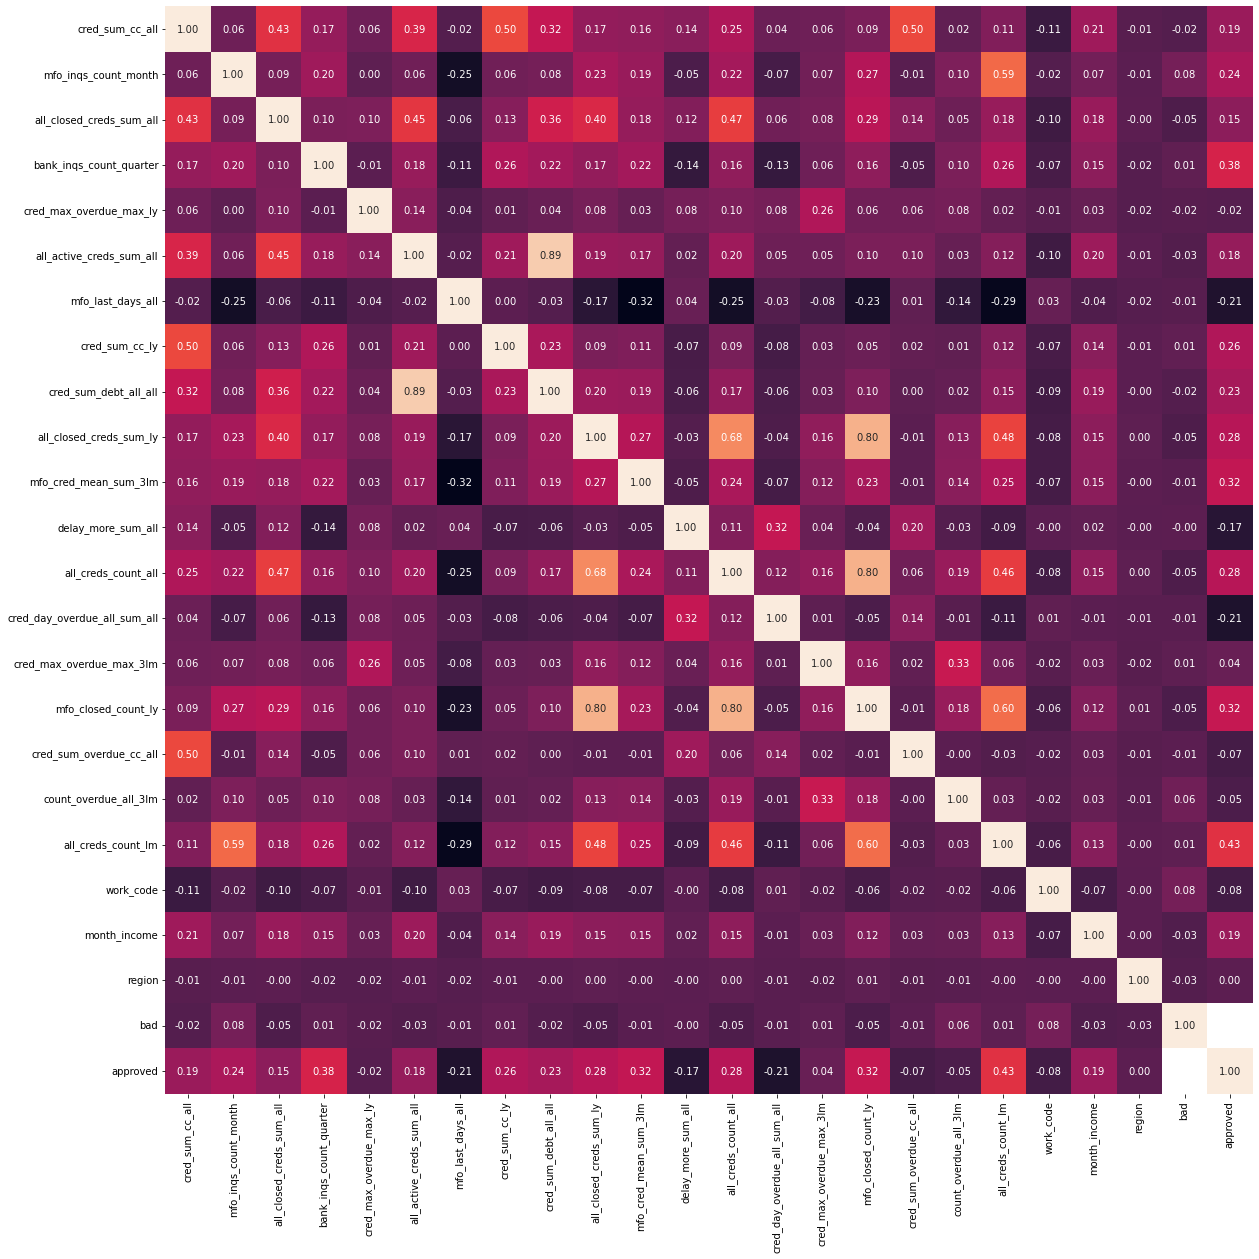

In [5]:
df = train_data

correlation_matrix = df.corr()

fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(correlation_matrix,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 cbar=False)
# fig.savefig('whole-dataset-corr-mat-heatmap.png', bbox_inches='tight')

**Based on heatmap:**
1. 89% correlation between **cred_sum_debt_all_all** and **all_active_creds_sum_all**. It is intuitive, the more credits person has, the more money he/she should pay every time period.
2. 80% correlation between **mfo_closed_count_ly** and **all_closed_creds_sum_ly**. It means that on average, 4 out of 5 closed credits client take from MFOs and 1 out of bank. It means that clients prefer MFOs more than banks or banks give far less credits, logically second one is more appropriate.
3. 68% correlation between **all_creds_count_all** and **all_closed_creds_sum_ly**. The more credits client repays, the more new credits he/she gets.
4. 60% correlation of **all_creds_count_lm** and **mfo_closed_count_ly**. The more credits client repays, the more he gets, very similar to **point 3**.
5. `region` and `work_code` columns are totally out of table, they have **zero linear correlation** with other data. It does not mean that there is no **non-linear correlation**, but, at least for the linear model training it will be derprecated. **Also**, `work_code` is actually a redundant information since it is more clearly represented in `month_income`.

#### 3.1.2. Correlation matrix (approved credits (bad != NaN) subset)

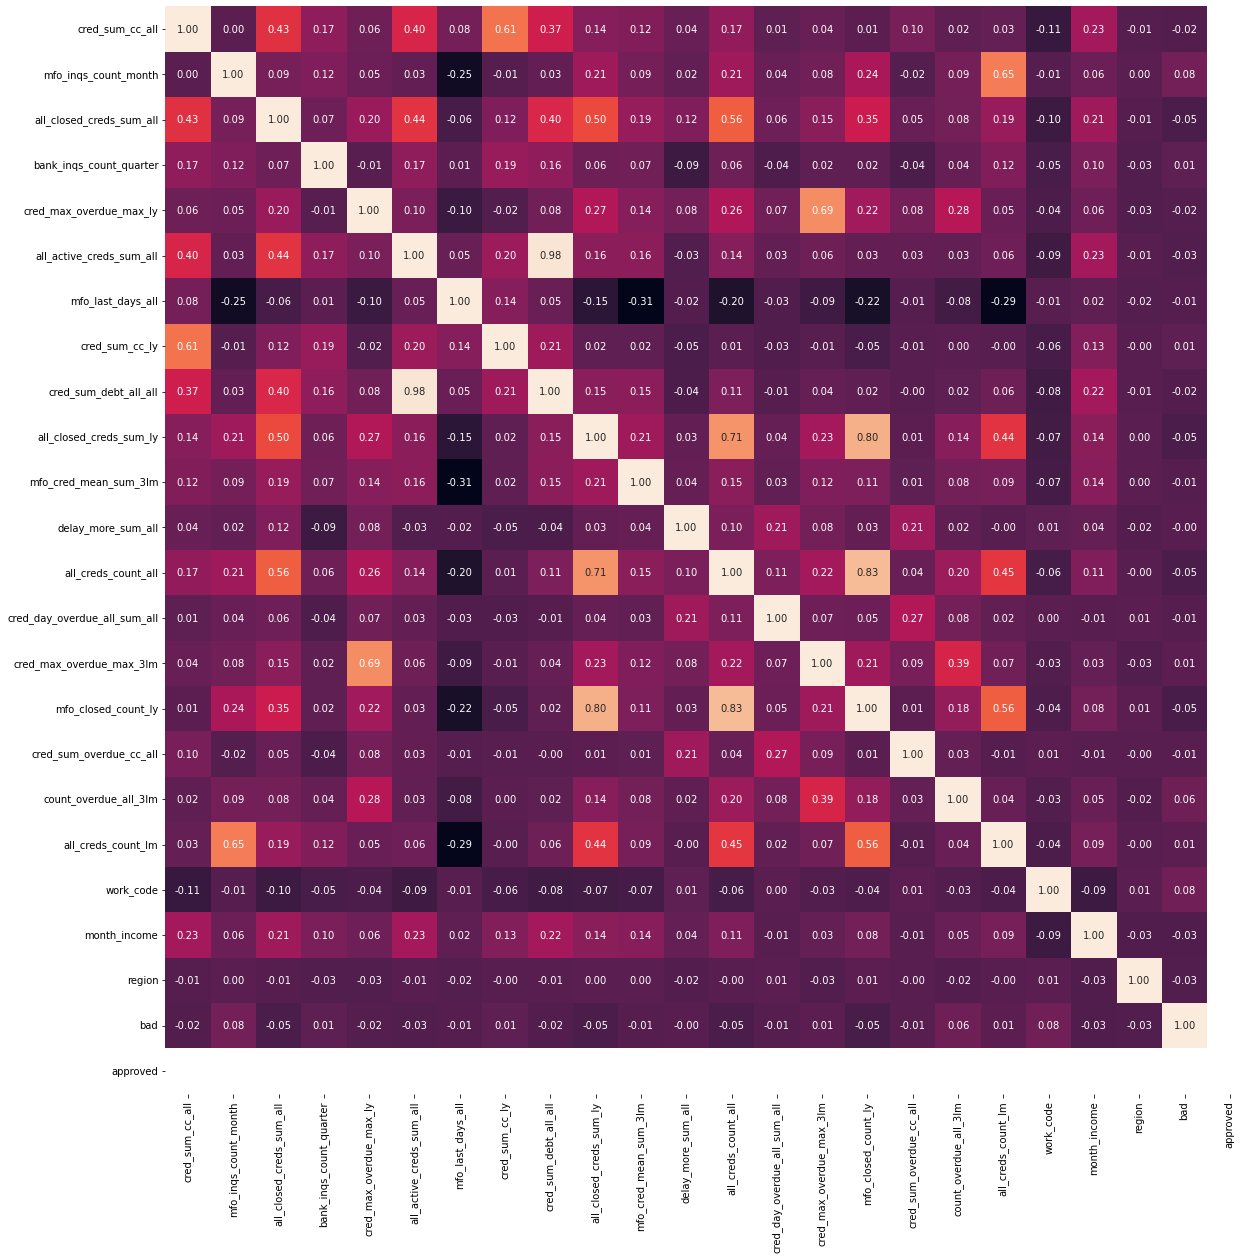

In [6]:
correlation_matrix_nona = df.dropna().corr()

fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(correlation_matrix_nona,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 cbar=False)
# fig.savefig('bad-subset-corr-mat-heatmap.png', bbox_inches='tight')

**Based on heatmap:**
1. The relationships remained almost the same, with increases in linear correlation coefficients.

### 3.2. Testing LogisticRegression estimator.

In [7]:
# Testing simple LogisticRegression
np.random.seed(4)

lr = LogisticRegression(max_iter=300)

shuffled_df = df.dropna().drop(['region', 'approved', 'work_code'], axis=1).sample(frac=1)

X = shuffled_df.drop(['bad'], axis=1)
y = shuffled_df['bad']

scaler = StandardScaler(with_mean=True,
                        with_std=True).fit(X)
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1103
         1.0       0.00      0.00      0.00       351

    accuracy                           0.76      1454
   macro avg       0.38      0.50      0.43      1454
weighted avg       0.58      0.76      0.65      1454



**Conclusion**: LogisticRegression predicts only negative values and therefore fails. It is clear that non-linear estimator should be used.

### 3.3. Features distributions.

#### 3.3.1. Plotting probability density curves.

/var/folders/sr/s8tdfzns1b5b8grynwwcxsv40000gn/T/ipykernel_4455/2518700858.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(nrows=1,


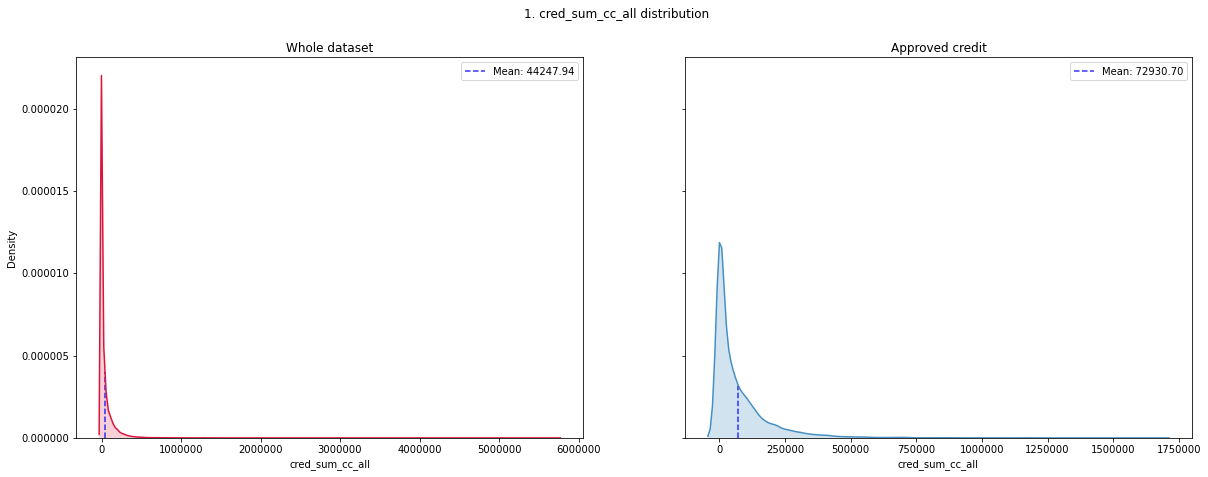

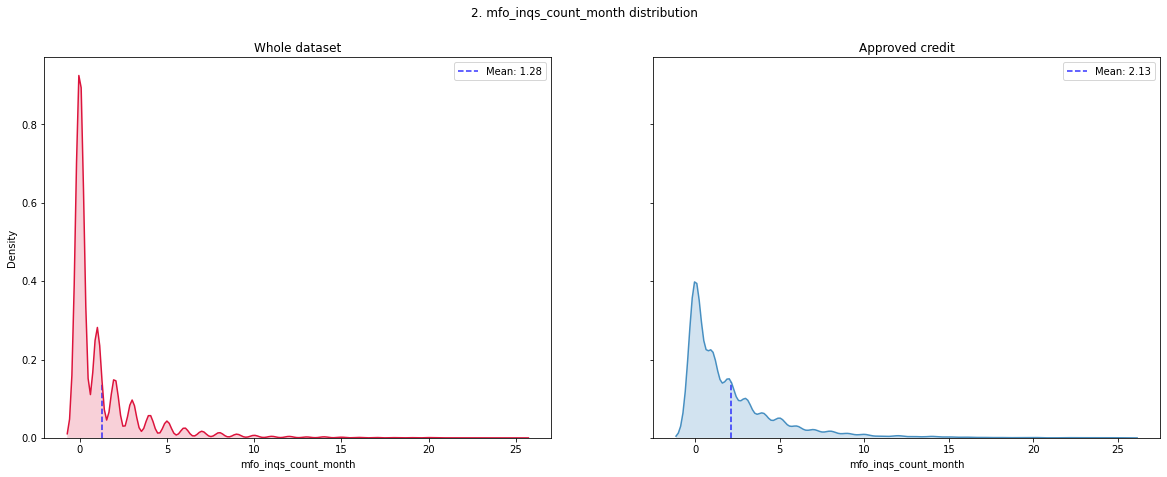

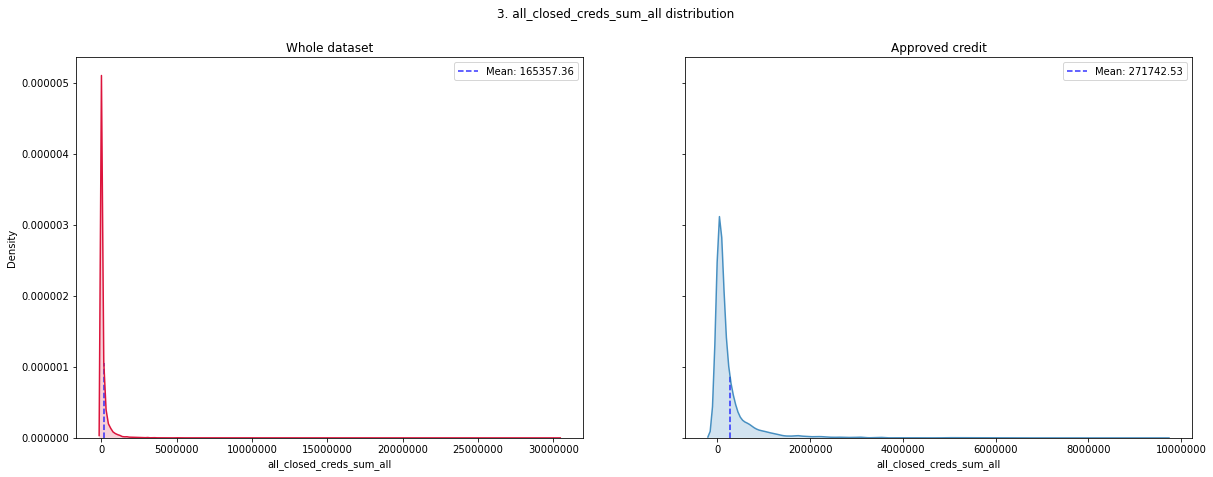

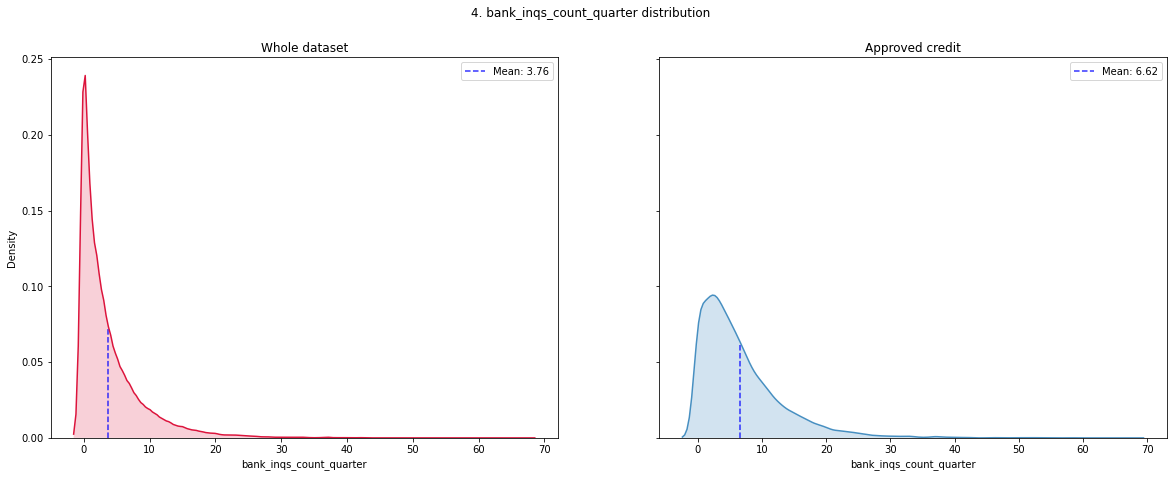

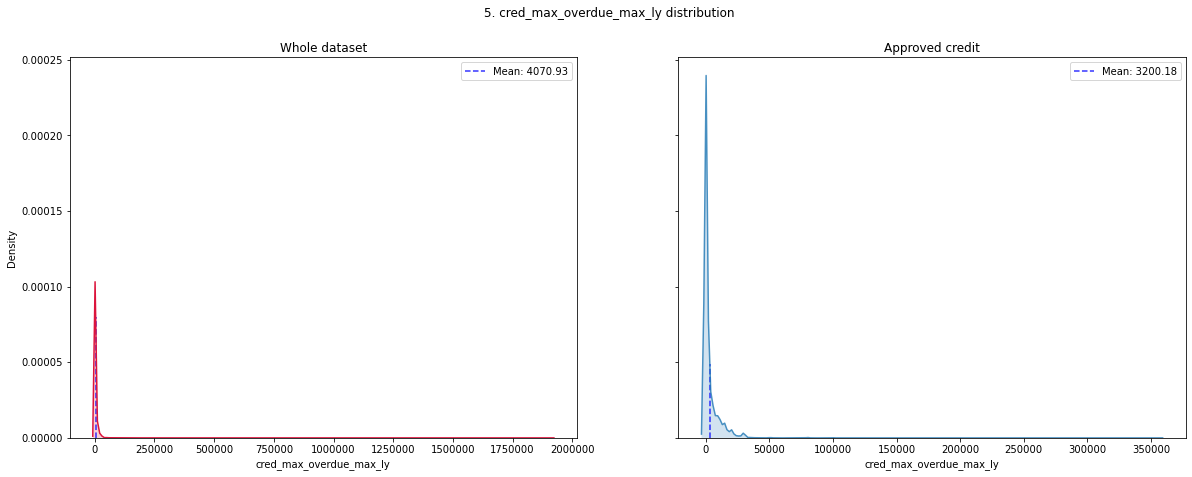

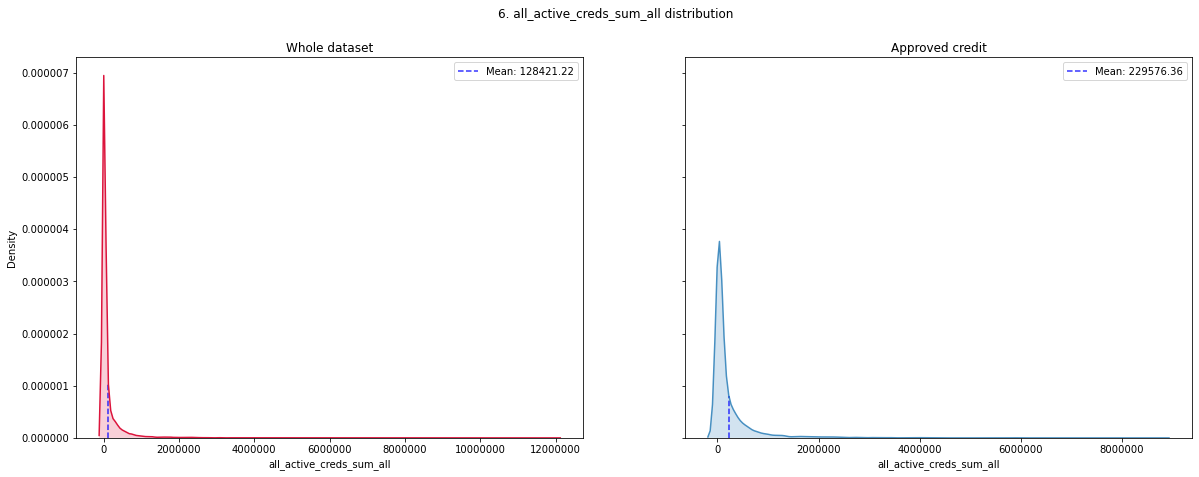

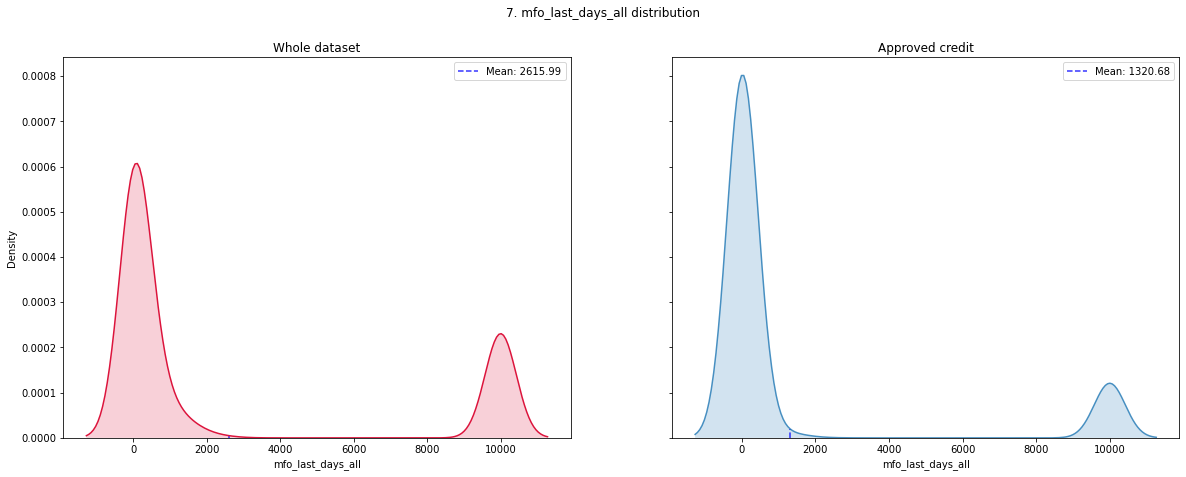

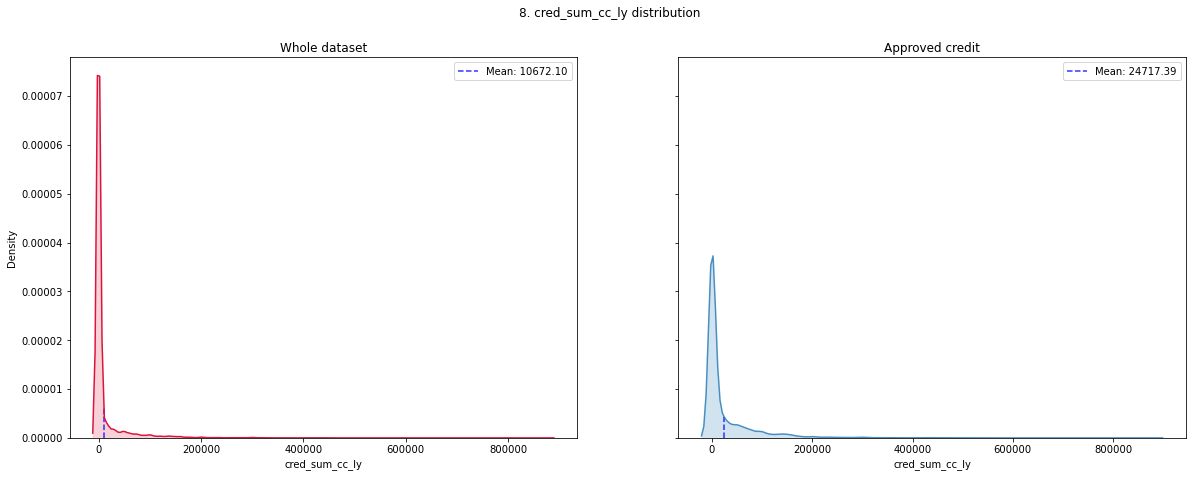

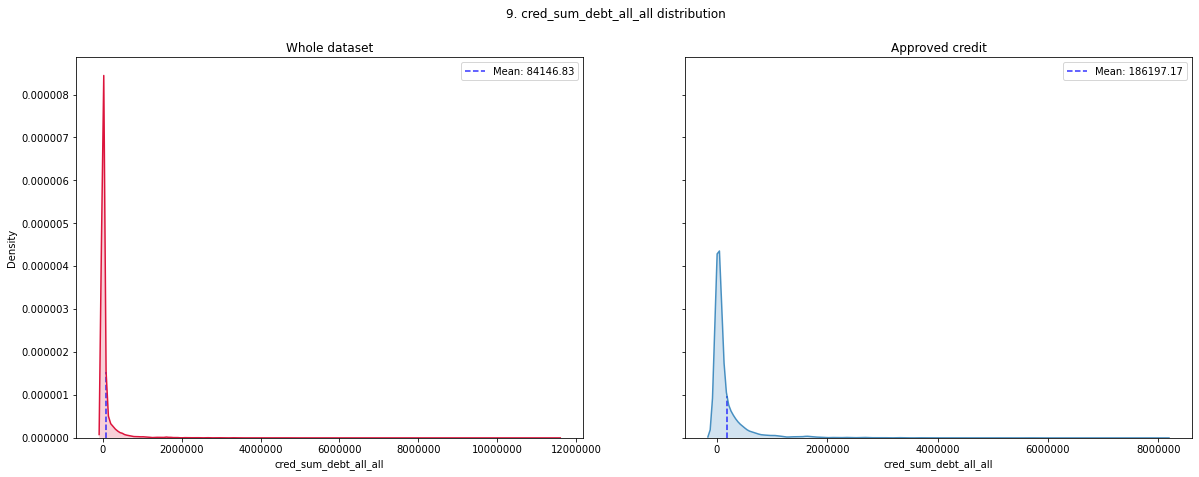

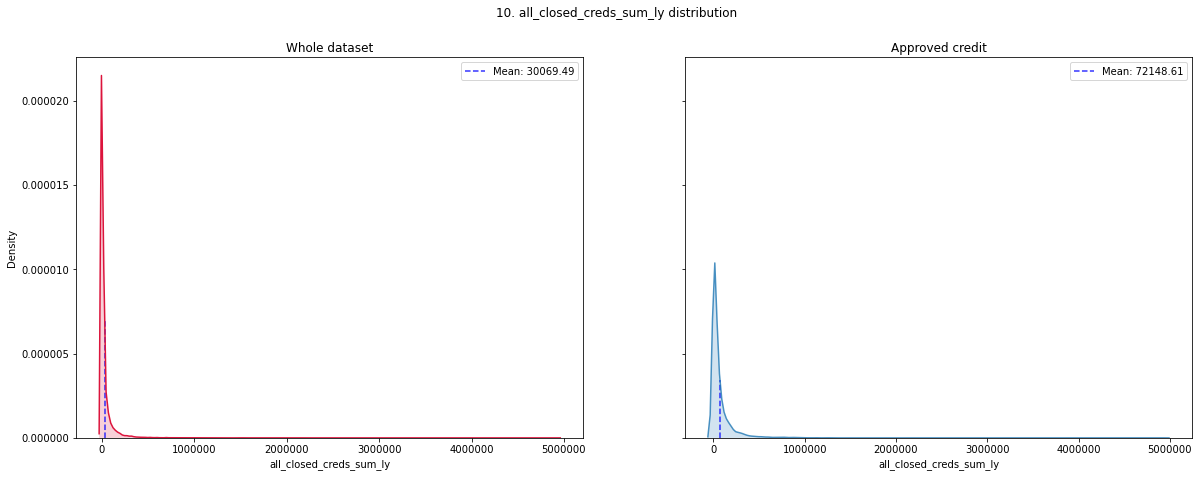

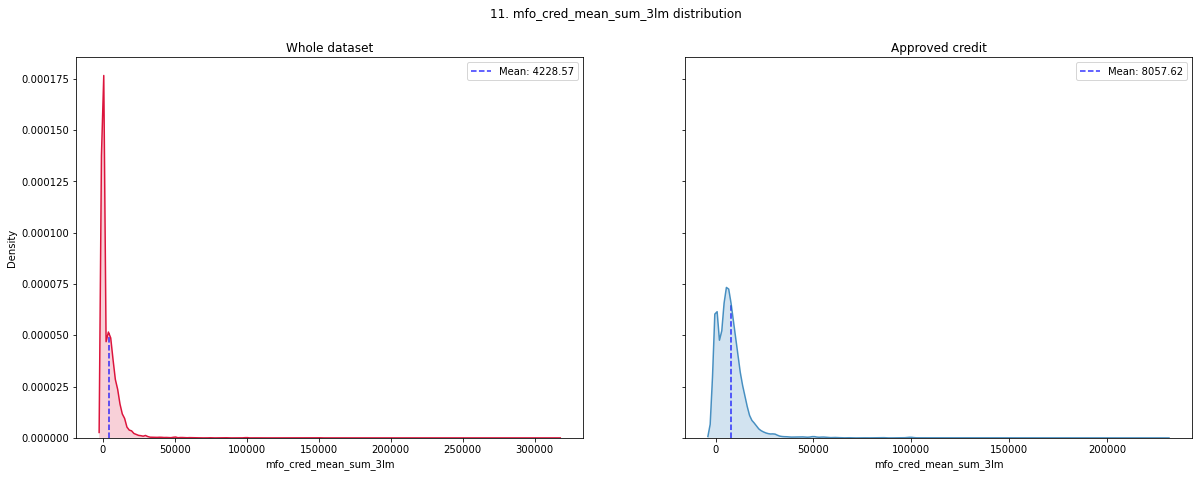

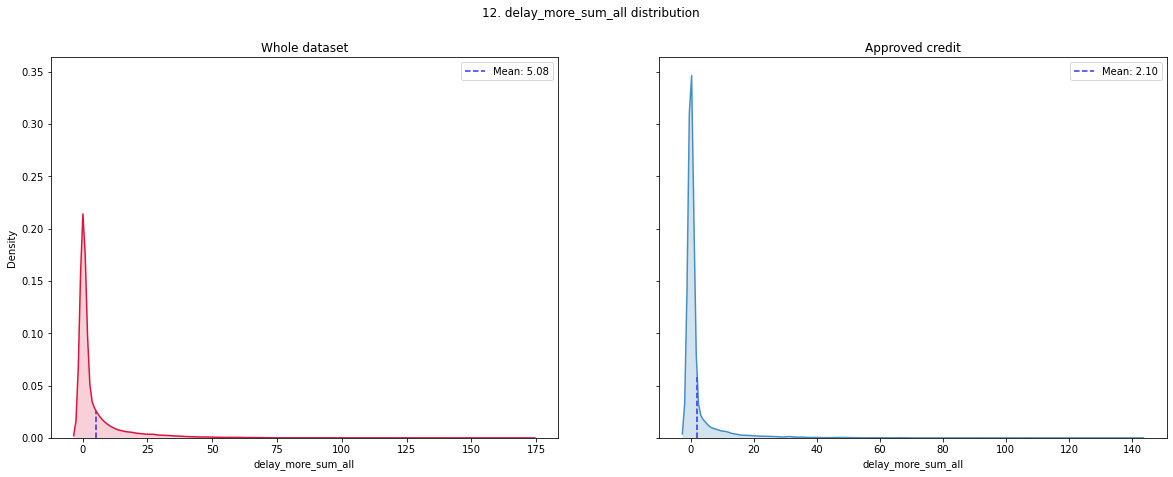

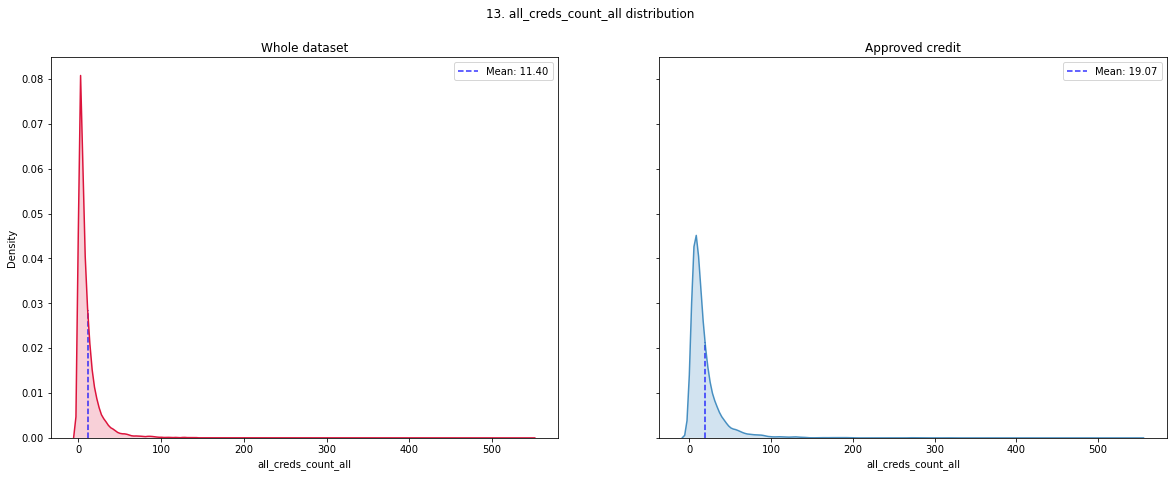

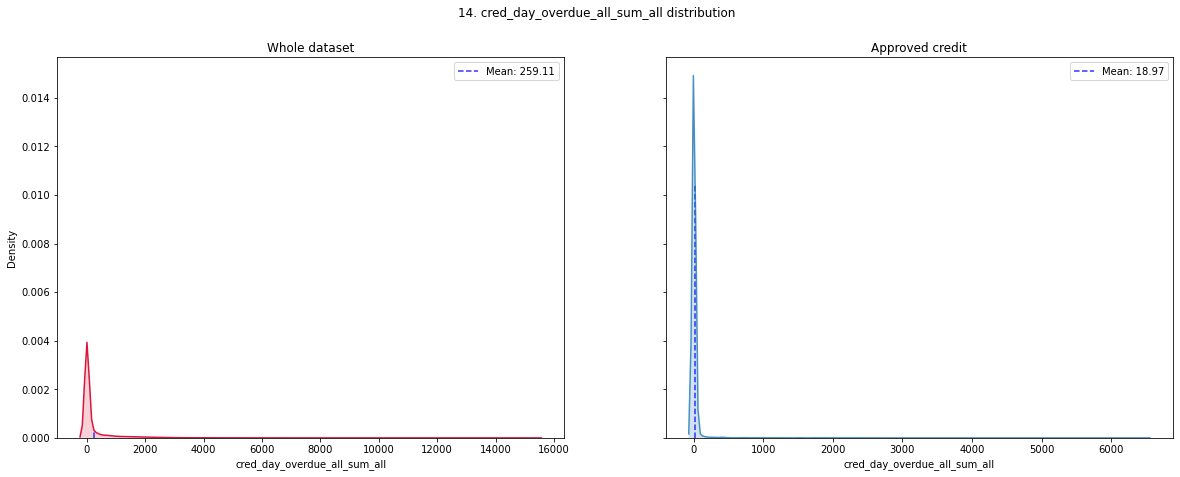

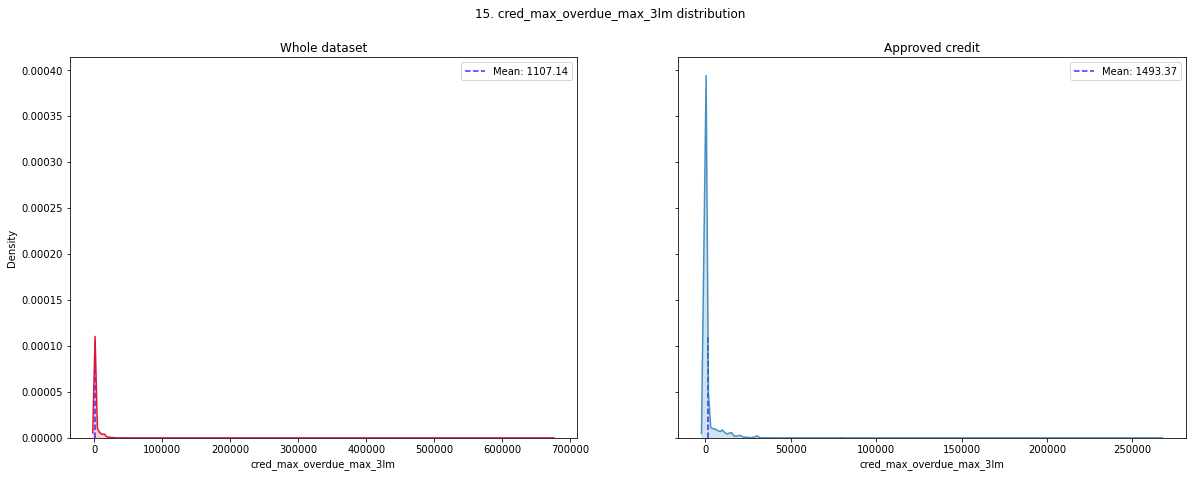

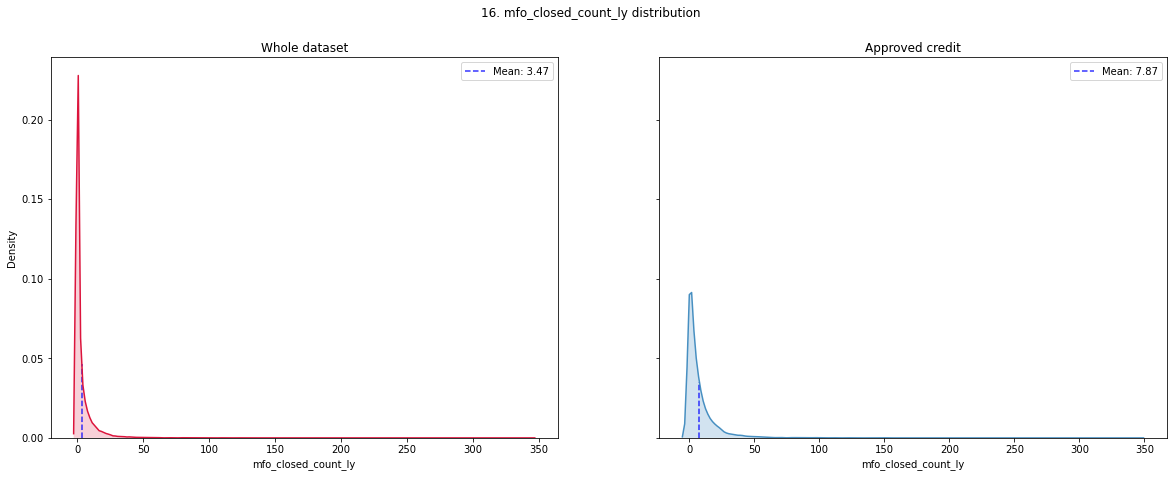

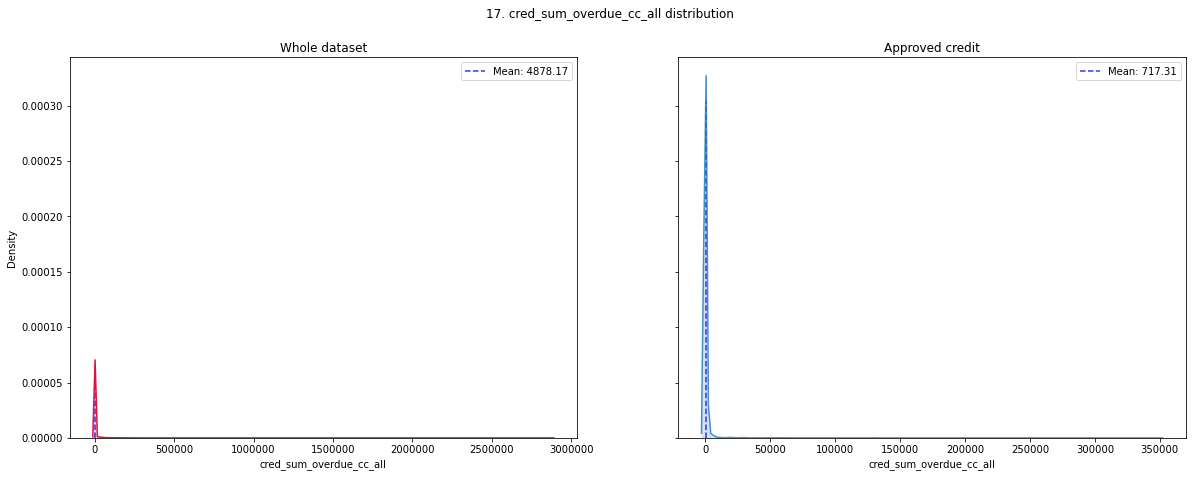

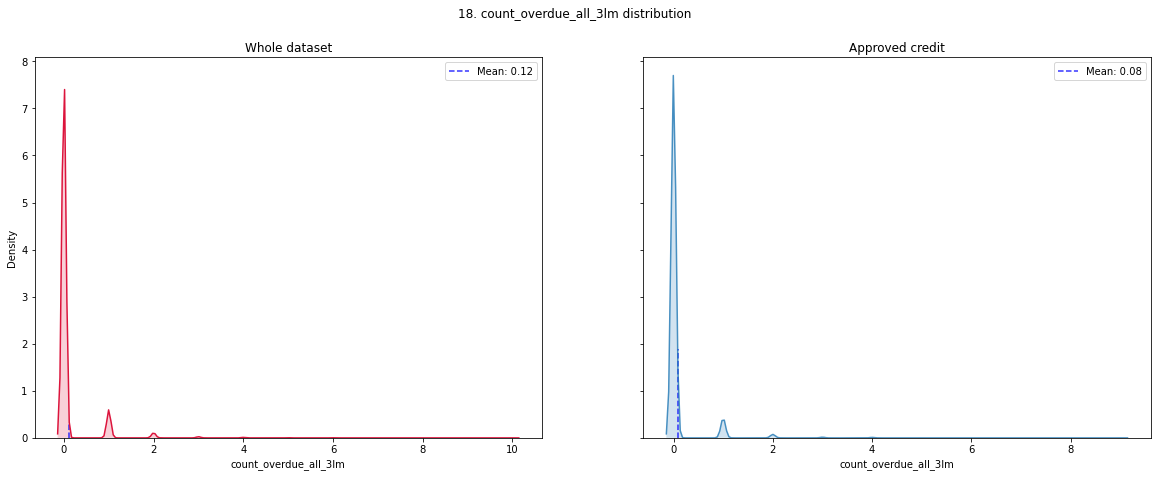

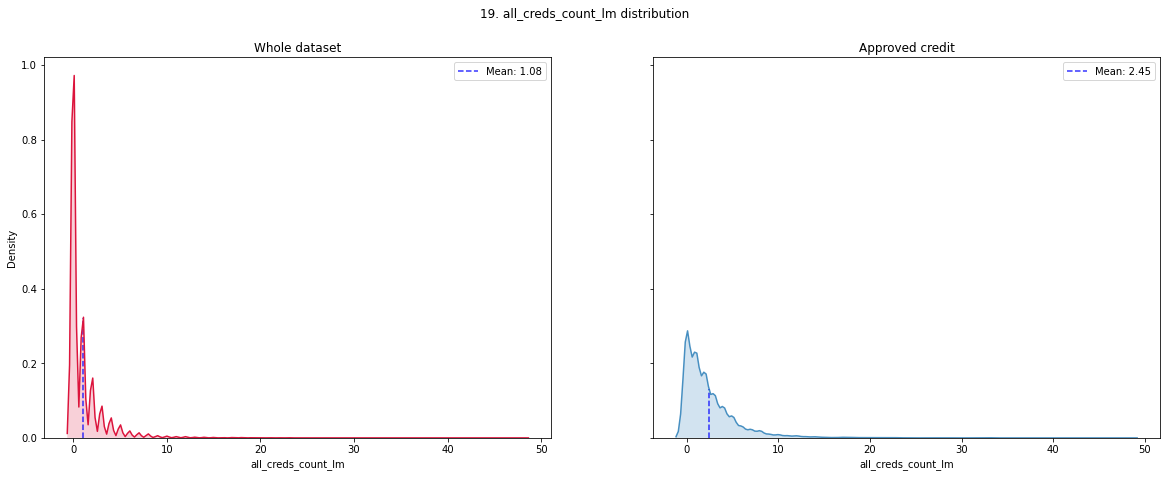

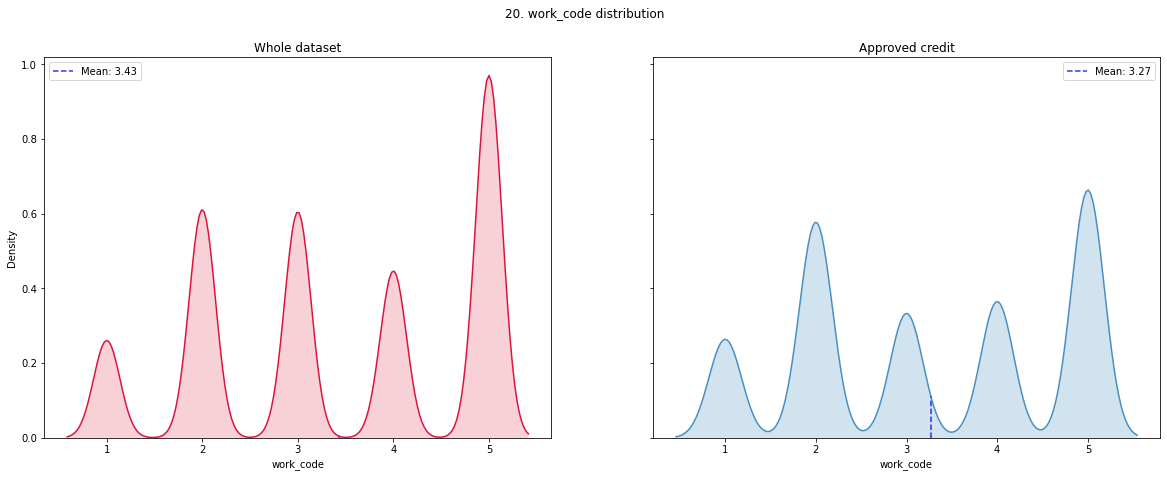

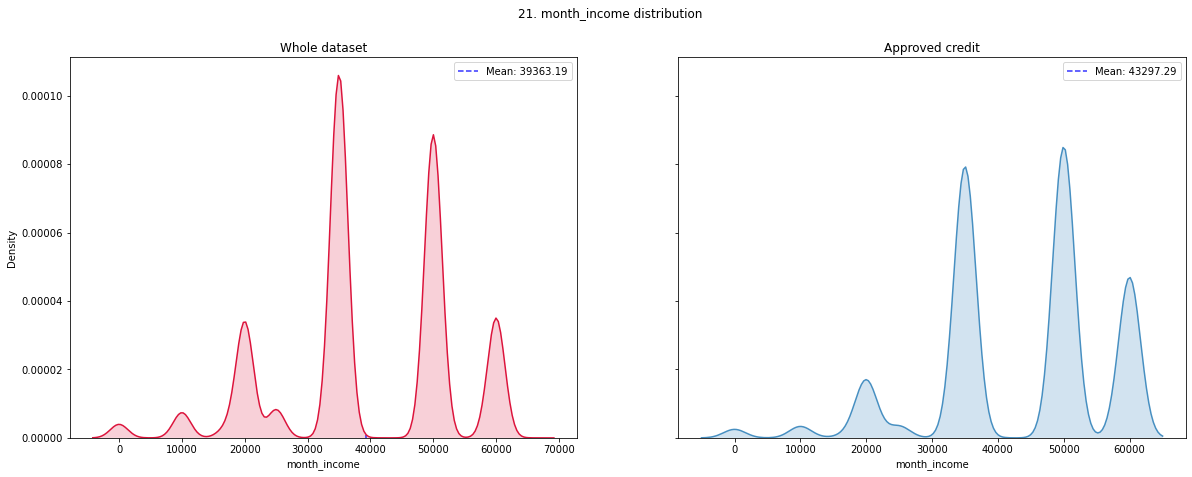

In [9]:
# Plotting distribution of features
def plot_feature(feature: str, i):
    fig, (ax1, ax2) = plt.subplots(nrows=1,
                                   ncols=2,
                                   figsize=(20, 7),
                                   sharey=True)

    feature_whole = df[feature]
    feature_nona = df.dropna()[feature]
    
    # First plot
    sns.kdeplot(x=feature_whole,
                fill=True,
                ax=ax1,
                bw_adjust=.75,
                shade=False,
                color='crimson')
    ax1.set(title='Whole dataset',
            ylabel='Density')
    
    kdeline = ax1.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    height_1 = np.interp(feature_whole.mean(), xs, ys)
    ax1.vlines(x=feature_whole.mean(),
               ymin=0,
               ymax=height_1,
               color='blue',
               linestyle='--',
               label=f'Mean: {feature_whole.mean():.2f}',
               alpha=0.8)
    
#     height_2 = np.interp(feature_whole.median(), xs, ys)
#     ax1.vlines(x=feature_whole.median(),
#                ymin=0,
#                ymax=height_2,
#                color='green',
#                linestyle='--',
#                label=f'Median: {feature_whole.median():.2f}',
#                alpha=0.8)
    
    ax1.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax1.legend()
    ax1.ticklabel_format(style='plain',
                         axis='both')

    # Second plot
    sns.kdeplot(x=feature_nona,
                fill=True,
                ax=ax2,
                bw_adjust=.75,
                alpha=0.8,
                shade=False)
    ax2.set(title='Approved credit',
            ylabel='Density')
    
    kdeline = ax2.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    height_1 = np.interp(feature_nona.mean(), xs, ys)
    ax2.vlines(x=feature_nona.mean(),
               ymin=0,
               ymax=height_1,
               color='blue',
               linestyle='--',
               label=f'Mean: {feature_nona.mean():.2f}',
               alpha=0.8)
    
#     height_2 = np.interp(feature_nona.median(), xs, ys)
#     ax2.vlines(x=feature_nona.median(),
#                ymin=0,
#                ymax=height_2,
#                color='green',
#                linestyle='--',
#                label=f'Median: {feature_nona.median():.2f}')
    
    ax2.fill_between(xs, 0, ys, alpha=0.2)
    ax2.legend()
    ax2.ticklabel_format(style='plain', axis='both')
    fig.suptitle(f"{i+1}. {feature} distribution")
#     fig.savefig(f"{i+1}-{feature}-distribution.png")
    

for i, feature in enumerate(df.columns[:21]):
    plot_feature(feature, i)

#### 3.3.2. Changes of feature trends (from left to right).

1. `cred_sum_cc_all`: **right skew**. People with approved credits have more active amount of money than dataset average.
2. `mfo_inqs_count_months`: **right skew**. People who get credit have on average **2.13** appeals to other mfos, whereas whole dataset is **1.28**.
3. `all_creds_sum_all`: no difference. Only higher mean of closed credits.
4. `bank_inqs_count_quarter`: **increased variance**. People who get a credit on average have **6.63** bank inqueries, which is almost 2 times the whole mean of **3.76**. They try more and it is worth.
5. `cred_max_overdue_max_ly`: no difference. Overdues are discouraged in mfos and banks.
6. `all_active_creds_sum_all`: no difference. Only higher mean of active money.
7. `mfo_last_days_all`: **peak increase**. People who get credits take them more often and therefore have less days from last mfo credit than whole dataset mean.
8. `cred_sum_cc_ly`: no difference. 
9. `cred_sum_debt_all_all`: no difference.
10. `all_closed_creds_sum_ly`: no difference. Two times higher mean of closed credits.
11. `mfo_cred_mean_sum_3lm`: **shift in distribution**. People who get credit have two times higher mean of money amount.
12. `delay_more_sum_all`: no difference. **5** delays of whole dataset compared to **2** delays of people who get credit.
13. `all_creds_count_all`: no difference. **11** approved credits compared to **19** approved credits.
14. `cred_day_overdue_all_sum_all`: **peak increase**. **256** days of active credits overdues compared to **19** days. It means, that odds of getting a credit with more than 30 days of overdue is very small.
15. `cred_max_overdue_max_3lm`: **left shift**. Whole dataset has lower mean of maximum debt overdue than people who got the credit, which is counter-intuitive.
16. `mfo_closed_count_ly`: no difference. **3.47** credits compared to **7.87** closed credits.
17. `cred_sum_overdue_cc_all`: **peak increase**. Lower credit cards overdues sum.
18. `count_overdue_all_3lm`: no difference. Means that it almost has no influence on given credit.
19. `all_creds_count_lm`: **right skew**. **1.08** mean of taken credits compared to **2.45**.
20. `work_code`: peaks dominations are almost the same. Work professions need credits the most.
21. `month_income`: no difference. Slight increase of mean income.

### 3.4. Testing RandomForestClassifier.

#### 3.4.1. Fit of the model.

In [10]:
# Testing non-linear relationships
np.random.seed(4)

rfc = RandomForestClassifier(n_estimators=1000, random_state=4)

rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7537826685006878

#### 3.4.2. Visualization of feature importances.

Text(0.5, 0.98, 'Feauture importances')

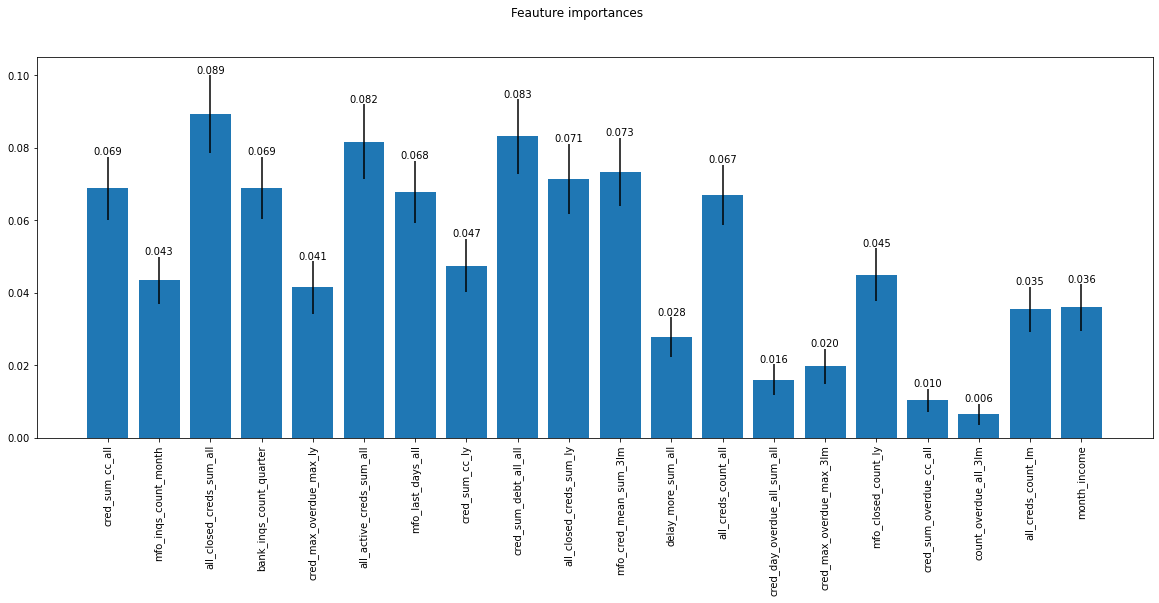

In [11]:
# Plotting RandomForestClassifier feature importances
fig, ax = plt.subplots(figsize=(20, 7))

x = df.drop(['bad', 'approved', 'region', 'work_code'], axis=1).columns
y = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
bar = ax.bar(x=x, height=y, yerr=std)
plt.xticks(rotation=90)
ax.bar_label(bar,
             fmt='%.3f');
fig.suptitle('Feauture importances')
# fig.savefig('feature-importances.png', bbox_inches='tight')

**Based on bar chart:**
1. Most important features are: `all_closed_creds_sum_all`, `cred_sum_debt_all_all`, and `all_active_creds_sum_all`.
2. Least important features are: `count_overdue_all_3lm` and `cred_sum_overdue_cc_all`.


Logically, while deciding whether or not to give a credit, one values how many credits potential client closed (**overall trend**), his/her sum of all active credits and sum of credits debt (**current situation**).


**NOTE**: some features could be good for a bad model and redundant for a good model, thus all above is probably biased.


#### 3.4.3. Compare to feature importances using permutation method.

In [12]:
result = {'importances_mean': np.array([ 1.20357634e-03, -3.78266850e-04,  9.62861073e-04,  4.74552957e-03,
         2.99174691e-03, -2.06327373e-03,  3.47317744e-03, -6.53370014e-04,
         0.00000000e+00,  1.61623109e-03,  1.37551582e-03, -6.87757909e-05,
        -9.62861073e-04,  9.62861073e-04,  2.13204952e-03,  1.51306740e-03,
         1.13480055e-03,  3.37001376e-03,  1.06602476e-03,  6.87757909e-04]),
 'importances_std': np.array([0.00222726, 0.00271185, 0.00182483, 0.00244033, 0.00202012,
        0.00119123, 0.00254075, 0.00190193, 0.0022602 , 0.00366049,
        0.00224971, 0.00116919, 0.00160411, 0.00098231, 0.00265389,
        0.00180135, 0.00076198, 0.0017521 , 0.00192664, 0.00217488]),
 'importances': np.array([[ 0.00343879,  0.00206327, -0.00068776,  0.00275103,  0.        ,
          0.00343879,  0.00275103, -0.00137552,  0.00343879, -0.00275103,
          0.00412655,  0.00068776,  0.00343879,  0.00275103, -0.00137552,
         -0.00275103, -0.00068776,  0.00206327,  0.00343879, -0.00068776],
        [ 0.        , -0.00275103, -0.00068776, -0.00137552,  0.00275103,
          0.00068776, -0.00137552, -0.00618982,  0.00206327,  0.00275103,
          0.        ,  0.00068776, -0.00137552,  0.        ,  0.00618982,
         -0.00137552,  0.00137552, -0.00481431, -0.00343879, -0.00068776],
        [ 0.00137552,  0.00206327,  0.00206327, -0.00068776,  0.00137552,
          0.        ,  0.00412655,  0.        , -0.00068776, -0.00275103,
         -0.00206327,  0.00137552,  0.00137552, -0.00137552,  0.00137552,
          0.00137552,  0.00206327,  0.00206327,  0.00481431,  0.00137552],
        [ 0.00137552,  0.00343879,  0.00412655,  0.00068776,  0.00412655,
          0.00343879,  0.00481431,  0.00412655,  0.00343879,  0.00756534,
          0.00343879,  0.00618982,  0.00412655,  0.00275103,  0.01169188,
          0.00481431,  0.00825309,  0.00618982,  0.00343879,  0.00687758],
        [ 0.00343879,  0.00618982,  0.00618982,  0.00275103,  0.00343879,
          0.        ,  0.        ,  0.00618982,  0.00481431,  0.00412655,
          0.00206327,  0.00412655,  0.00206327,  0.00481431,  0.00206327,
          0.00412655,  0.00137552,  0.00137552,  0.        ,  0.00068776],
        [ 0.        , -0.00206327, -0.00137552, -0.00068776, -0.00206327,
         -0.00068776, -0.00206327, -0.00137552, -0.00412655, -0.00343879,
         -0.00206327, -0.00068776, -0.00343879, -0.00412655, -0.00068776,
         -0.00206327, -0.00343879, -0.00275103, -0.00137552, -0.00275103],
        [ 0.00275103,  0.00412655, -0.00068776,  0.00618982,  0.00550206,
          0.00275103, -0.00137552,  0.00412655,  0.00343879,  0.00825309,
          0.00137552,  0.00137552,  0.00894085,  0.00481431,  0.00206327,
          0.00343879,  0.00481431,  0.00343879,  0.00343879,  0.00068776],
        [-0.00275103, -0.00068776, -0.00206327,  0.        , -0.00481431,
         -0.00206327,  0.00068776, -0.00275103, -0.00137552, -0.00275103,
          0.00275103,  0.00275103,  0.00068776, -0.00206327,  0.00068776,
          0.00137552,  0.00068776, -0.00068776, -0.00068776,  0.        ],
        [ 0.00343879, -0.00068776,  0.00206327,  0.        ,  0.00137552,
          0.00137552, -0.00068776, -0.00343879, -0.00343879,  0.        ,
          0.00137552,  0.00343879, -0.00275103, -0.00481431,  0.        ,
         -0.00068776,  0.00068776, -0.00068776,  0.00343879,  0.        ],
        [ 0.00068776,  0.00481431,  0.00687758, -0.00206327,  0.00550206,
          0.        ,  0.00137552, -0.00343879, -0.00275103,  0.00068776,
          0.00687758,  0.        , -0.00137552,  0.00343879, -0.00206327,
          0.00618982,  0.00550206, -0.00550206,  0.00412655,  0.00343879],
        [ 0.        ,  0.00068776, -0.00068776,  0.00343879,  0.00550206,
          0.00343879, -0.00206327,  0.00206327,  0.00275103,  0.00068776,
          0.        , -0.00068776, -0.00068776,  0.00068776,  0.00275103,
          0.00481431,  0.00481431, -0.00068776,  0.00275103, -0.00206327],
        [-0.00275103, -0.00137552,  0.00068776,  0.        ,  0.00206327,
          0.00068776, -0.00137552,  0.00068776,  0.00068776, -0.00137552,
          0.        ,  0.        ,  0.00068776,  0.00137552, -0.00137552,
          0.        ,  0.00137552, -0.00137552,  0.        ,  0.        ],
        [ 0.        ,  0.00137552, -0.00343879, -0.00137552,  0.        ,
          0.        ,  0.00137552, -0.00068776, -0.00412655, -0.00068776,
         -0.00137552,  0.00068776, -0.00275103, -0.00343879, -0.00137552,
          0.00068776, -0.00275103, -0.00068776, -0.00137552,  0.00068776],
        [ 0.        ,  0.00137552,  0.00206327,  0.00206327,  0.        ,
          0.00137552, -0.00068776, -0.00068776,  0.00068776,  0.        ,
          0.00068776,  0.00137552,  0.00275103,  0.00137552,  0.00137552,
          0.00275103,  0.00068776,  0.00137552,  0.        ,  0.00068776],
        [ 0.00550206, -0.00137552,  0.00687758,  0.00275103,  0.00481431,
          0.00068776, -0.00068776,  0.00206327, -0.00206327,  0.00412655,
          0.00068776,  0.        ,  0.00068776,  0.00550206,  0.00068776,
          0.00412655,  0.00618982,  0.00206327, -0.00137552,  0.00137552],
        [ 0.00343879,  0.00687758,  0.        ,  0.00068776,  0.00275103,
          0.00068776, -0.00068776,  0.00137552,  0.00068776, -0.00068776,
          0.00275103,  0.00068776,  0.00275103,  0.00137552,  0.00137552,
          0.00275103,  0.        ,  0.00343879, -0.00068776,  0.00068776],
        [ 0.00068776,  0.00137552,  0.00068776,  0.00068776,  0.        ,
          0.00275103,  0.00137552,  0.00206327,  0.00068776,  0.00206327,
          0.00137552,  0.00068776,  0.        ,  0.00275103,  0.00068776,
          0.00137552,  0.00068776,  0.00068776,  0.00137552,  0.00068776],
        [ 0.00412655,  0.00343879,  0.00343879,  0.00343879,  0.00550206,
          0.00550206,  0.00137552,  0.00343879, -0.00206327,  0.00206327,
          0.00550206,  0.00343879,  0.00550206,  0.00137552,  0.00412655,
          0.00343879,  0.00412655,  0.00412655,  0.00206327,  0.00343879],
        [-0.00137552,  0.00206327, -0.00137552, -0.00206327, -0.00068776,
          0.00275103, -0.00068776,  0.00275103,  0.00068776,  0.00206327,
          0.00618982,  0.00068776,  0.00068776,  0.00068776,  0.00206327,
          0.00343879,  0.00068776,  0.00275103,  0.        ,  0.        ],
        [ 0.00137552,  0.00137552, -0.00412655, -0.00137552,  0.        ,
          0.00206327, -0.00137552,  0.00137552, -0.00068776,  0.00275103,
          0.00412655,  0.00481431,  0.        ,  0.00068776,  0.00137552,
          0.00206327, -0.00343879,  0.00206327, -0.00068776,  0.00137552]])}

Text(0.5, 0.98, 'Feature importances (permutation)')

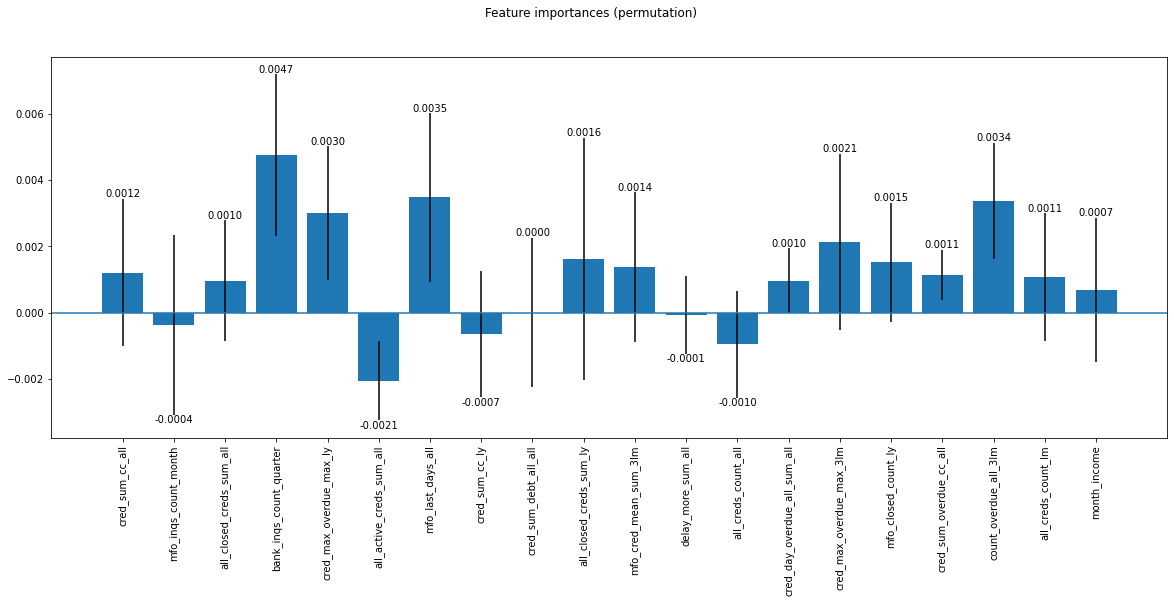

In [13]:
# Using permutation importance
np.random.seed(4)

fig, ax = plt.subplots(figsize=(20, 7))

# result = permutation_importance(rfc, X_test, y_test, n_repeats=20, random_state=4)

x = df.drop(['bad', 'approved', 'region', 'work_code'], axis=1).columns
y = [i.mean() for i in result["importances"]]
bar = ax.bar(x=x, height=y, yerr=result["importances_std"])
plt.xticks(rotation=90)
ax.bar_label(bar,
             fmt='%.4f')
ax.axhline(0);
fig.suptitle("Feature importances (permutation)")
# fig.savefig('feature-importances-permutation.png', bbox_inches='tight')

#### 3.4.4. Perform forward feature selection (15 best variables).

In [14]:
# Took about 15 minutes to calculate
def evaluate_metric(model, x_cv, y_cv):
    return f1_score(y_cv, model.predict(x_cv), average='micro')


def forward_feature_selection(x_train, x_cv, y_train, y_cv, n):
    """
    Input : Dataframe df with m features, number of required features n
    Output : Set of n features most useful for model performance
    Decision function: f1_score
    """
    feature_set = []
    for num_features in range(n):
        metric_list = []
        model = RandomForestClassifier(n_estimators=1000,
                                       random_state=4)
        for feature in x_train.columns:
            if feature not in feature_set:
                f_set = feature_set.copy()
                f_set.append(feature)
                model.fit(x_train[f_set], y_train)
                metric_list.append((evaluate_metric(model, x_cv[f_set], y_cv), feature))

        metric_list.sort(key=lambda x : x[0], reverse = True)
        feature_set.append(metric_list[0][1])
    return feature_set


# forward_feature_selection(X_train, X_test, y_train, y_test, 15)

In [15]:
# 15 best features for RFC out of 22
best_features = ['bank_inqs_count_quarter',
 'cred_sum_overdue_cc_all',
 'count_overdue_all_3lm',
 'cred_max_overdue_max_3lm',
 'cred_day_overdue_all_sum_all',
 'delay_more_sum_all',
 'cred_max_overdue_max_ly',
 'all_creds_count_lm',
 'all_closed_creds_sum_all',
 'all_creds_count_all',
 'mfo_last_days_all',
 'mfo_closed_count_ly',
 'mfo_cred_mean_sum_3lm',
 'month_income',
 'cred_sum_cc_all']

#### 3.4.5. Testing RandomForestClassifier with 15 best features.

In [16]:
# Testing best features with previous rfc
np.random.seed(4)

X = shuffled_df[best_features]
y = shuffled_df['bad']

scaler = StandardScaler(with_mean=True,
                        with_std=True).fit(X)

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)

print(classification_report(y_test, y_preds))
print(rfc.score(X_test, y_test))

              precision    recall  f1-score   support

         0.0       0.73      0.98      0.84      1052
         1.0       0.45      0.04      0.08       402

    accuracy                           0.72      1454
   macro avg       0.59      0.51      0.46      1454
weighted avg       0.65      0.72      0.63      1454

0.7207702888583218


**Based on section 3.4:**
1. Model predicts only  **4%** true **bad=1** values, which is bad.
2. According to results of feature permutation, model has large amount of instability. It means that some variables are making no sense to model and should be removed.
3. Model identified **45%** of true positives/chosen positives, but only **4%** of true positives/all positives. Even having **98%** of true negatives/all negatives and **73%** of true negatives/ chosen negatives, the overall result is 72%.
4. Model cannot properly identify true values.

### 3.5. Feature selection using baseline results.

#### 3.5.1. Comparison of criteria for variables.

* Change in distribution.
* Permutation feature importance of RandomForestClassifier.
* Forward feature selection results.


1. `bank_inqs_count_quarter`. This variable has the best score in forward feature selection, only positive result on model's performance, and resembles gaussian distribution with mean not in 0.
2. `month_income`. It has shift and different peak in distribution.
3. `all_creds_count_lm`. It has gaussian distribution across subset.
4. `mfo_cred_mean_sum_3lm`. It has has gaussian distribution across subset.
5. `cred_day_overdue_all_sum_all`. This variable has more than 1000% difference between mean values of whole dataset and the subset.
6. `mfo_closed_count_ly`.
7. `work_code`.
8. `cred_sum_cc_all`.
9. `cred_sum_overdue_cc_all`.
10. `cred_max_overdue_max_3lm`.
11. `mfo_inqs_count_month`.
12. `mfo_last_days_all`.

**NOTE**: the features without reasoning are taken based on distribution changes.

**Trial 1**: train LR and RFC with 5 best features.

In [17]:
def evaluate_model(model, X_test, y_test):
    """
    Makes 5-folded CV.
    :return: dict, keys: tuples of (n_features, score); values: list of features.
    """
    np.random.seed(4)
    
    cv_score = np.mean(cross_val_score(model, X_test, y_test))
    print(f"Number of features: {model.n_features_in_}")
    print(f"5-folded CV score: {cv_score * 100:.3f}%")
    y_preds = model.predict(X_test)
    print(classification_report(y_test, y_preds))
    
    return {(model.n_features_in_, round(cv_score, 3)): model.feature_names_in_}

In [18]:
# Training LR on 5 features
df_nona = df.dropna()

X = df_nona[['bank_inqs_count_quarter',
             'month_income',
             'all_creds_count_lm',
             'mfo_cred_mean_sum_3lm',
             'cred_day_overdue_all_sum_all']]

y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
np.random.seed(4)

lr_2 = LogisticRegression(max_iter=1000)
lr_2.fit(X_train, y_train)
evaluate_model(lr_2, X_test, y_test);

Number of features: 5
5-folded CV score: 72.559%
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84      1059
         1.0       0.00      0.00      0.00       395

    accuracy                           0.73      1454
   macro avg       0.36      0.50      0.42      1454
weighted avg       0.53      0.73      0.61      1454



/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [20]:
np.random.seed(4)

rfc_2 = RandomForestClassifier(random_state=4)
rfc_2.fit(X_train, y_train)
evaluate_model(rfc_2, X_test, y_test);

Number of features: 5
5-folded CV score: 67.056%
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80      1059
         1.0       0.28      0.13      0.18       395

    accuracy                           0.68      1454
   macro avg       0.51      0.50      0.49      1454
weighted avg       0.61      0.68      0.63      1454



**Trial 1 conclusion**:
1. LR model fails with this amount of features as well. It is not relevant model for that problem.
2. Random forest identifies **5%** of all positive values, which is the same as with 15 best values from forward feature selection.

**Trial 2**: train RFC with 7 best values.

In [21]:
np.random.seed(4)

X = df_nona[['bank_inqs_count_quarter',
            'month_income',
            'all_creds_count_lm',
            'mfo_cred_mean_sum_3lm',
            'cred_day_overdue_all_sum_all',
            'work_code',
            'mfo_closed_count_ly']]

y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc_3 = RandomForestClassifier(random_state=4)
rfc_3.fit(X_train, y_train)
evaluate_model(rfc_3, X_test, y_test);

Number of features: 7
5-folded CV score: 70.083%
              precision    recall  f1-score   support

         0.0       0.72      0.93      0.82      1041
         1.0       0.39      0.11      0.17       413

    accuracy                           0.70      1454
   macro avg       0.56      0.52      0.49      1454
weighted avg       0.63      0.70      0.63      1454



**Trial 2 conclusion**:
1. **11%** recall compared to previous 5%.
2. **Lower** cv score.


#### 3.5.2. Forward feature selection - finding optimal number of features.

Previously, `f1_score` metric was used to evaluate the model performance. Now, `recall_score` will be used because this metric is crucial for potential model usage.

In [22]:
def forward_feature_selection_2(x_train, x_cv, y_train, y_cv, n):
    """
    Input : Dataframe df with m features, number of required features n
    Output : Set of n features most useful for model performance
    Decision function: recall_score
    Hyperparameters: n_estimators=300, random_state=4
    """
    np.random.seed(4)
    feature_set = []
    for num_features in range(n):
        metric_list = []
        model = RandomForestClassifier(n_estimators=300,
                                       random_state=4)
        for feature in x_train.columns:
            if feature not in feature_set:
                f_set = feature_set.copy()
                f_set.append(feature)
                model.fit(x_train[f_set], y_train)
                metric_list.append((evaluate_metric_2(model, x_cv[f_set], y_cv), feature))

        metric_list.sort(key=lambda x : x[0], reverse = True)
        feature_set.append(metric_list[0][1])
    return feature_set


def evaluate_metric_2(model, x_cv, y_cv):
    return recall_score(y_cv, model.predict(x_cv), average='micro')


def train_forest(features):
    np.random.seed(4)

    X = df_nona[features]

    y = df_nona['bad']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    forest = RandomForestClassifier(random_state=4)
    forest.fit(X_train, y_train)
    return evaluate_model(forest, X_test, y_test)

**Trial 3**: FFS 7/10

In [23]:
np.random.seed(4)

X = df_nona[['bank_inqs_count_quarter',
             'month_income',
             'all_creds_count_lm',
             'mfo_cred_mean_sum_3lm',
             'cred_day_overdue_all_sum_all',
             'work_code',
             'mfo_closed_count_ly',
             'cred_sum_cc_all',
             'cred_sum_overdue_cc_all',
             'cred_max_overdue_max_3lm']]

y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# features_1 = forward_feature_selection_2(X_train, X_test, y_train, y_test, 7)
# train_forest(features_1);

In [25]:
# Number of features: 7
# 5-folded CV score: 66.577%
#               precision    recall  f1-score   support

#          0.0       0.73      0.90      0.81      1041
#          1.0       0.40      0.16      0.23       413

#     accuracy                           0.69      1454
#    macro avg       0.56      0.53      0.52      1454
# weighted avg       0.64      0.69      0.64      1454


# ['month_income',
#  'work_code',
#  'cred_sum_overdue_cc_all',
#  'cred_day_overdue_all_sum_all',
#  'cred_max_overdue_max_3lm',
#  'all_creds_count_lm',
#  'mfo_closed_count_ly']

**Trial 3 conclusion**:
1. **16%** recall for bad=1 values, higher than previously.
2. **Lower** cv score.

**Trial 4**: FFS 7/12

In [26]:
np.random.seed(4)

X = df_nona[['bank_inqs_count_quarter',
             'month_income',
             'all_creds_count_lm',
             'mfo_cred_mean_sum_3lm',
             'cred_day_overdue_all_sum_all',
             'work_code',
             'mfo_closed_count_ly',
             'cred_sum_cc_all',
             'cred_sum_overdue_cc_all',
             'cred_max_overdue_max_3lm',
             'mfo_inqs_count_month',
             'mfo_last_days_all']]

y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
# features_2 = forward_feature_selection_2(X_train, X_test, y_train, y_test, 7)
# train_forest(features_2);

In [28]:
# Number of features: 7
# 5-folded CV score: 66.577%
#               precision    recall  f1-score   support

#          0.0       0.73      0.90      0.81      1041
#          1.0       0.40      0.16      0.23       413

#     accuracy                           0.69      1454
#    macro avg       0.56      0.53      0.52      1454
# weighted avg       0.64      0.69      0.64      1454


# ['month_income',
#  'work_code',
#  'cred_sum_overdue_cc_all',
#  'cred_day_overdue_all_sum_all',
#  'cred_max_overdue_max_3lm',
#  'all_creds_count_lm',
#  'mfo_closed_count_ly']

**Trial 3 conclusion**:
1. No change even with two more variables (compared to **Trial 2**) --> these two are bad ones.


**Trial 4**: perform FFS on whole range of 22 features, for 5-17 best features.

In [29]:
def multiple_ffs(lower, upper, X_train, X_test, y_train, y_test):
    """
    Performs FFS across range of best features from *lower* to *upper* (inclusively).
    :return: dict, keys: tuples of (n_features, score); values: list of features.
    """
    features_list = []
    for n in range(lower, upper+1, 1):
        features = forward_feature_selection_2(X_train, X_test, y_train, y_test, n)
        features_list.append(train_forest(features))
    return features_list

In [30]:
np.random.seed(4)

X = df_nona.drop(['bad', 'approved'], axis=1)
y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# features_list = multiple_ffs(5, 12, X_train, X_test, y_train, y_test)

In [31]:
np.random.seed(4)

X = df_nona.drop(['bad', 'approved'], axis=1)
y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# features_list = multiple_ffs(13, 17, X_train, X_test, y_train, y_test)

In [32]:
# [{(5,
#    0.68): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm'], dtype=object)},
#  {(6,
#    0.675): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm'], dtype=object)},
#  {(7,
#    0.666): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month'], dtype=object)},
#  {(8,
#    0.665): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income'], dtype=object)},
#  {(9,
#    0.658): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly'],
#         dtype=object)},
#  {(10,
#    0.682): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly'], dtype=object)},
#  {(11,
#    0.704): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter'], dtype=object)},
#  {(12,
#    0.706): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all'], dtype=object)}],
#  {(13,
#    0.704): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all', 'region'], dtype=object)},
#  {(14,
#    0.714): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all', 'region', 'mfo_closed_count_ly'],
#         dtype=object)},
#  {(15,
#    0.711): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all', 'region', 'mfo_closed_count_ly',
#          'mfo_last_days_all'], dtype=object)},
#  {(16,
#    0.714): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all', 'region', 'mfo_closed_count_ly',
#          'mfo_last_days_all', 'mfo_cred_mean_sum_3lm'], dtype=object)},
#  {(17,
#    0.715): array(['delay_more_sum_all', 'cred_sum_overdue_cc_all',
#          'count_overdue_all_3lm', 'cred_day_overdue_all_sum_all',
#          'cred_max_overdue_max_3lm', 'all_creds_count_lm',
#          'mfo_inqs_count_month', 'month_income', 'cred_max_overdue_max_ly',
#          'all_closed_creds_sum_ly', 'bank_inqs_count_quarter',
#          'cred_sum_debt_all_all', 'region', 'mfo_closed_count_ly',
#          'mfo_last_days_all', 'mfo_cred_mean_sum_3lm', 'cred_sum_cc_all'],
#         dtype=object)}]

**Trial 4 conclusion**:
1. list of 3 best recall features - [10, 11, 8].
2. CV score increases with greater number of features but still recall_score for bad=1 is very small.


**Trial 5**: make multiple FFS with other metric - getting tpr and evaluating it.

In [33]:
def forward_feature_selection_3(x_train, x_cv, y_train, y_cv, n):
    """
    Input : Dataframe df with m features, number of required features n
    Output : Set of n features most useful for model performance
    Decision function: tp
    Hyperparameters: n_estimators=300, random_state=4
    """
    np.random.seed(4)
    feature_set = []
    for num_features in range(n):
        metric_list = []
        model = RandomForestClassifier(n_estimators=300,
                                       random_state=4)
        for feature in x_train.columns:
            if feature not in feature_set:
                f_set = feature_set.copy()
                f_set.append(feature)
                model.fit(x_train[f_set], y_train)
                metric_list.append((evaluate_metric_3(model, x_cv[f_set], y_cv), feature))

        metric_list.sort(key=lambda x : x[0], reverse = True)
        feature_set.append(metric_list[0][1])
    return feature_set


def evaluate_metric_3(model, x_cv, y_cv):
    y_preds = model.predict(x_cv)
    ((tn, fp), (fn, tp)) = confusion_matrix(y_cv, y_preds)
    return tp

def multiple_ffs_2(lower, upper, X_train, X_test, y_train, y_test):
    """
    Performs FFS across range of best features from *lower* to *upper* (inclusively).
    :return: dict, keys: tuples of (n_features, score); values: list of features.
    """
    features_list = []
    for n in range(lower, upper+1, 1):
        features = forward_feature_selection_3(X_train, X_test, y_train, y_test, n)
        features_list.append(train_forest(features))
    return features_list

In [34]:
np.random.seed(4)

X = df_nona.drop(['bad', 'approved'], axis=1)
y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# tpr_features = multiple_ffs_2(5, 17, X_train, X_test, y_train, y_test)

In [35]:
tpr_features = [{(5,
   0.625): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all'])},
 {(6,
   0.635): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm'])},
 {(7,
   0.65): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly'])},
 {(8,
   0.648): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all'])},
 {(9,
   0.67): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month'])},
 {(10,
   0.661): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code'])},
 {(11,
   0.667): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm'])},
 {(12,
   0.68): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all'])},
 {(13,
   0.693): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
         'mfo_closed_count_ly'])},
 {(14,
   0.695): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
         'mfo_closed_count_ly', 'all_closed_creds_sum_ly'])},
 {(15,
   0.708): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
         'mfo_closed_count_ly', 'all_closed_creds_sum_ly',
         'bank_inqs_count_quarter'])},
 {(16,
   0.711): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_al
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
         'mfo_closed_count_ly', 'all_closed_creds_sum_ly',
         'bank_inqs_count_quarter', 'cred_sum_cc_ly'])},
 {(17,
   0.708): (['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
         'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
         'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
         'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
         'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
         'mfo_closed_count_ly', 'all_closed_creds_sum_ly',
         'bank_inqs_count_quarter', 'cred_sum_cc_ly', 'mfo_last_days_all'])}]

**Trial 5 conclusion**:
1. Increasing number of used features correlates with decreasing TP score.
2. The optimal number of features is 5-8.

## 4. Modelling 1 (dropping NaN values).

### 4.1. RFC

In [36]:
feats = [['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all'],
         ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
          'cred_max_overdue_max_3lm'],
         ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
          'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly'],
         ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
          'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
          'cred_day_overdue_all_sum_all']]

In [37]:
def modelling(feats):
    """
    Takes in a list of feature lists.
    :return: list of dicts of format (number of features used to fit, model score, tp): {best parameters}
    """
    np.random.seed(4)
    feat_scores = []
    for feat in feats:
        X = df_nona[feat]
        y = df_nona['bad']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        grid = {"n_estimators": [100, 150, 200],
                "max_features": ['auto'],
                "criterion": ['gini'],
                "max_depth": [None, 15],
                "min_samples_split": [2, 4, 6],
                "min_samples_leaf": [1, 2, 4]}
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=grid,
                           n_jobs=-1,
                           cv=5)
        clf.fit(X_train, y_train)
        feat_scores.append({(len(feat), clf.score(X_test, y_test), evaluate_metric_3(clf, X_test, y_test)): clf.best_params_})
    
    return feat_scores




In [38]:
# rfc_results = modelling(feats)

In [39]:
rfc_results = [{(5, 0.7138927097661623, 3): {'criterion': 'gini',
   'max_depth': 15,
   'max_features': 'auto',
   'min_samples_leaf': 4,
   'min_samples_split': 6,
   'n_estimators': 100}},
 {(6, 0.7269601100412655, 6): {'criterion': 'gini',
   'max_depth': 15,
   'max_features': 'auto',
   'min_samples_leaf': 4,
   'min_samples_split': 4,
   'n_estimators': 200}},
 {(7, 0.7379642365887208, 6): {'criterion': 'gini',
   'max_depth': 15,
   'max_features': 'auto',
   'min_samples_leaf': 2,
   'min_samples_split': 2,
   'n_estimators': 150}},
 {(8, 0.7310866574965612, 5): {'criterion': 'gini',
   'max_depth': 15,
   'max_features': 'auto',
   'min_samples_leaf': 4,
   'min_samples_split': 2,
   'n_estimators': 150}}]

In [40]:
def train_forest_params(features, params):
    np.random.seed(4)

    X = df_nona[features]

    y = df_nona['bad']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    forest = RandomForestClassifier()
    forest.set_params(**params)
    
    forest.fit(X_train, y_train)
    return evaluate_model(forest, X_test, y_test)

In [41]:
f = ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
          'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly']
p = {'criterion': 'gini',
     'max_depth': 15,
     'max_features': 'auto',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 150}
train_forest_params(f, p);

Number of features: 7
5-folded CV score: 70.634%
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84      1041
         1.0       0.64      0.02      0.04       413

    accuracy                           0.72      1454
   macro avg       0.68      0.51      0.44      1454
weighted avg       0.70      0.72      0.61      1454



### 4.2. CatBoostClassifier

In [42]:
def train_cat_params(features, params):
    np.random.seed(4)

    X = df_nona[features]

    y = df_nona['bad']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    cat = CatBoostClassifier()
    cat.set_params(**params)
    
    cat.fit(X_train, y_train)
    return evaluate_cat(cat, X_test, y_test)


def evaluate_cat(model, X_test, y_test):
    """
    Makes 5-folded CV.
    :return: dict, keys: tuples of (n_features, score); values: list of features.
    """
    np.random.seed(4)
    
    cv_score = np.mean(cross_val_score(model, X_test, y_test))
    print(f"Number of features: {model.n_features_in_}")
    print(f"5-folded CV score: {cv_score * 100:.3f}%")
    y_preds = model.predict(X_test)
    print(classification_report(y_test, y_preds))
    
    return {(len(X_test.columns), round(cv_score, 3)): X_test.columns}

14 features: 0.24 tp and 64.3% cv score

In [43]:
p = {"learning_rate": 1,
     "random_seed": 4,
     "verbose": False,
     "iterations": 1000,
     "auto_class_weights": 'Balanced',
     "depth": 8,
     "l2_leaf_reg": 3}

f = ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
          'count_overdue_all_3lm', 'cred_sum_overdue_cc_all']

In [44]:
# for f in tpr_features:
#     train_cat_params(list(f.values())[0], p)

**Results**:

In [45]:
# Using [0.75, 1] weights

# Number of features: 7
# 5-folded CV score: 62.588%
#               precision    recall  f1-score   support

#          0.0       0.72      0.77      0.74      1041
#          1.0       0.29      0.24      0.26       413

#     accuracy                           0.62      1454
#    macro avg       0.51      0.50      0.50      1454
# weighted avg       0.60      0.62      0.61      1454


# Using auto_class_weights - "Balanced"

# Number of features: 10
# 5-folded CV score: 60.386%
#               precision    recall  f1-score   support

#          0.0       0.73      0.73      0.73      1041
#          1.0       0.32      0.31      0.31       413

#     accuracy                           0.61      1454
#    macro avg       0.52      0.52      0.52      1454
# weighted avg       0.61      0.61      0.61      1454


# Using 
# p = {"learning_rate": 1,
#      "random_seed": 4,
#      "verbose": False,
#      "iterations": 1000,
#      "auto_class_weights": 'Balanced',
#      "depth": 8,
#      "l2_leaf_reg": 3}

# Number of features: 16
# 5-folded CV score: 64.239%
#               precision    recall  f1-score   support

#          0.0       0.73      0.78      0.75      1041
#          1.0       0.33      0.28      0.30       413

#     accuracy                           0.63      1454
#    macro avg       0.53      0.53      0.53      1454
# weighted avg       0.62      0.63      0.62      1454

**Based on model's performances**:
1. RFC does not exceed 0.24 recall for bad=1, all models with recall score >0.20 show at most 61% cv score.
2. CBC has the highest recall score of 0.28 while maintaining cv score of 64.2% (using 16 features).


### 4.3. Tuning final model.

As a final model CBC with 16 features will be used. Now, CBC will be tuned with `grid_search`.

In [46]:
# 16 features
final_feats = ['cred_sum_debt_all_all', 'month_income', 'delay_more_sum_all',
              'count_overdue_all_3lm', 'cred_sum_overdue_cc_all',
              'cred_max_overdue_max_3lm', 'cred_max_overdue_max_ly',
              'cred_day_overdue_all_sum_all', 'mfo_inqs_count_month',
              'work_code', 'all_creds_count_lm', 'all_active_creds_sum_all',
              'mfo_closed_count_ly', 'all_closed_creds_sum_ly',
              'bank_inqs_count_quarter', 'cred_sum_cc_ly']

In [47]:
np.random.seed(4)

X = df_nona[final_feats]

y = df_nona['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

final_model = CatBoostClassifier(loss_function='Logloss')

grid = {"learning_rate": [0.5, 1, 1.5],
        "random_seed": [4],
        "iterations": [1000],
        "auto_class_weights": ['Balanced'],
        "depth": [4, 6, 8, 10],
        "l2_leaf_reg": [1, 3, 5, 7, 9],
        "verbose": [False]}

# final_model_tuning_1 = final_model.grid_search(param_grid=grid,
#             X=X_train,
#             y=y_train,
#             cv=5,
#             partition_random_seed=4,
#             calc_cv_statistics=False,
#             search_by_train_test_split=False,
#             refit=True,
#             shuffle=True,
#             stratified=None,
#             verbose=False,
#             plot=True)

In [48]:
{'depth': 4,
  'random_seed': 4,
  'l2_leaf_reg': 9,
  'iterations': 1000,
  'learning_rate': 0.5,
  'auto_class_weights': 'Balanced'};


# 0.6176066024759285
#               precision    recall  f1-score   support

#          0.0       0.72      0.77      0.74      1041
#          1.0       0.29      0.24      0.26       413

#     accuracy                           0.62      1454
#    macro avg       0.50      0.50      0.50      1454
# weighted avg       0.60      0.62      0.61      1454

### 4.4. Final model test and conclusion.

Usage of `grid_search` leaded to nothing, it has shown improvement in neither recall nor overall accuracy.
Therefore, the final model is CBC from previous stage with 16 features.

In [49]:
cat = CatBoostClassifier(learning_rate=1,
                         random_seed=4,
                         verbose=False,
                         iterations=1000,
                         auto_class_weights='Balanced',
                         depth=8,
                         l2_leaf_reg=3)

cat.fit(X_train, y_train)
y_preds = cat.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.73      0.78      0.75      1041
         1.0       0.33      0.28      0.30       413

    accuracy                           0.63      1454
   macro avg       0.53      0.53      0.53      1454
weighted avg       0.62      0.63      0.62      1454



In [50]:
test_data = pd.read_csv('test.csv')

X_last = test_data.dropna()[final_feats]
y_last = test_data.dropna()['bad']

y_preds = cat.predict(X_last)

print(classification_report(y_last, y_preds))

              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       274
         1.0       0.31      0.28      0.30        99

    accuracy                           0.64       373
   macro avg       0.53      0.53      0.53       373
weighted avg       0.63      0.64      0.64       373



### 4.5. Results.

In [51]:
# pickle.dump(cat, open('CBC-model-1.pkl', 'wb'))

In [52]:
[feat for feat in df.drop(['bad', 'approved', 'region'], axis=1).columns if feat not in final_feats]

['cred_sum_cc_all',
 'all_closed_creds_sum_all',
 'mfo_last_days_all',
 'mfo_cred_mean_sum_3lm',
 'all_creds_count_all']

1. The features above are not used for model training, 16 used.
2. CatBoostClassifier is the estimator for final model.
3. The main problem of model is its ability to identify overdue credits (bad=1). Overall score of model could be higher if it predicts every credit to be returned (bad=0), which is approximately 72% accuracy. However, it totally fails as a machine learning algorithm.
4. On final test, model had 64% accuracy and found 28% of all credits which were overdue.


## 5. Algorithm to replace NaN values.

### 5.1. Hypothesis.

1. NaN values could be marked using two approaches - **assigning** `0` and `1` values, or marking them as **new category**. Second option is irrelevant, since there is no sense in predicting this new category because it is 100% influenced by `approved` variable. Therefore, the only choice is to somehow mark missing target samples with `0` and `1` values.

2. This could be accomplished by simply taking a final model and predicting missing target values. However, this method is biased for several reasons. First of all, metrics of model are far from best ones, the given results could be too inaccurate. Second, according to statistics, about **1 out of 4** clients, who got an approved credit, overdue it. This percentage must be higher for clients who got a disapproved credit. Assuming that there is **certain reasoning behind actions** (they do not randomly choose to give credit or not) of people who were deciding whether or not to approve a credit, the percentage of bad=1 must be a lot higher.

3. Imagine, there is a descent slope of probability estimates (function) - whether or not this person is going to overdue a credit or not (actually, figuring out this function is the main purpose of project), from 0% to 100%, based on his/her data. Model says: 'There is a 50% (or 30%, or 1%, or 90%) chance this client overdues a credit'. What is a **boundary probability which is still acceptable to approve a credit**? Around which value the decision from giving a credit **changes** to not giving a credit? Let's call this percentage a **decision probability threshold** (DPT).

4. Assume DPT is 65%. It means that range of probabilities is from 65% to 100%. So, it is possible to predict probabilities using `predict_proba` and everything **>0.65** assign a bad=0 (credit returned) and **<0.65** - bad=1.

5. DPT could be figured out if the ratio of bad=0 to bad=1 is known. Default value is 50%. Since CBC model predicts less bad=1 values than there is, the DPT should be more than 50%.

6. At DPT=0.75, the ratio is about 0.5, which is possibly near the real **average value of all clients who got a disapproved credit**.

7. Hypithesis is that DPT is **0.75**.

In [53]:
df.dropna()['bad'].value_counts()

0.0    5306
1.0    1963
Name: bad, dtype: int64

In [54]:
def check_threshold(threshold):
    np.random.seed(4)
    
    df_na = df.loc[df.bad.isna() == True]

    X = df_na[final_feats]
    
    y_preds = cat.predict_proba(X)
    
    labels = []
    for i in y_preds:
        if i[0] > threshold:
            labels.append(0)
        else:
            labels.append(1)
    return pd.DataFrame(labels, columns=['bad'])

In [55]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for threshold in thresholds:
    labels = check_threshold(threshold)
    print(f"Threshold is: {threshold}")
    print(labels.value_counts())
    print(f"0 to 1 ratio: {len([l for l in labels['bad'] if l == 0])/len([l for l in labels['bad'] if l == 1])}")
    print(f"Probability of bad=0: {len([l for l in labels['bad'] if l == 0])/len(labels)}")
    print("")

Threshold is: 0.5
bad
0      9817
1      6030
dtype: int64
0 to 1 ratio: 1.6280265339966833
Probability of bad=0: 0.6194863381081592

Threshold is: 0.55
bad
0      9576
1      6271
dtype: int64
0 to 1 ratio: 1.5270291819486526
Probability of bad=0: 0.6042784123177889

Threshold is: 0.6
bad
0      9344
1      6503
dtype: int64
0 to 1 ratio: 1.436875288328464
Probability of bad=0: 0.5896384173660629

Threshold is: 0.65
bad
0      9088
1      6759
dtype: int64
0 to 1 ratio: 1.3445776002367213
Probability of bad=0: 0.5734839401779517

Threshold is: 0.7
bad
0      8819
1      7028
dtype: int64
0 to 1 ratio: 1.2548377916903812
Probability of bad=0: 0.5565091184451316

Threshold is: 0.75
bad
0      8521
1      7326
dtype: int64
0 to 1 ratio: 1.1631176631176632
Probability of bad=0: 0.5377042973433458

Threshold is: 0.8
bad
0      8131
1      7716
dtype: int64
0 to 1 ratio: 1.053784344219803
Probability of bad=0: 0.5130939610020824

Threshold is: 0.85
bad
1      8128
0      7719
dtype: int64
0

### 5.2. Applying hypothesis.

In [56]:
np.random.seed(4)

df_na = df.loc[df.bad.isna() == True]

X = df_na[final_feats]

y_preds = cat.predict_proba(X)

labels = []
for i in y_preds:
    if i[0] > 0.75:
        labels.append(0)
    else:
        labels.append(1)

df_na['bad'] = labels

/var/folders/sr/s8tdfzns1b5b8grynwwcxsv40000gn/T/ipykernel_4455/2781239920.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['bad'] = labels


In [57]:
df_full = pd.concat([df.dropna(), df_na])
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23116 entries, 5499365 to 6697264
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cred_sum_cc_all               23116 non-null  float64
 1   mfo_inqs_count_month          23116 non-null  int64  
 2   all_closed_creds_sum_all      23116 non-null  int64  
 3   bank_inqs_count_quarter       23116 non-null  int64  
 4   cred_max_overdue_max_ly       23116 non-null  float64
 5   all_active_creds_sum_all      23116 non-null  int64  
 6   mfo_last_days_all             23116 non-null  int64  
 7   cred_sum_cc_ly                23116 non-null  float64
 8   cred_sum_debt_all_all         23116 non-null  float64
 9   all_closed_creds_sum_ly       23116 non-null  int64  
 10  mfo_cred_mean_sum_3lm         23116 non-null  float64
 11  delay_more_sum_all            23116 non-null  int64  
 12  all_creds_count_all           23116 non-null  int64 

## 6. Modelling 2 (replacing NaN values).

In [58]:
np.random.seed(4)

cat_2 = CatBoostClassifier(learning_rate=1,
                           random_seed=4,
                           verbose=False,
                           iterations=1000,
                           auto_class_weights='Balanced',
                           depth=8,
                           l2_leaf_reg=3)

X = df_full[final_feats]
y = df_full['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cat_2.fit(X_train, y_train)
print(classification_report(y_test, cat_2.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      2790
         1.0       0.74      0.74      0.74      1834

    accuracy                           0.79      4624
   macro avg       0.78      0.78      0.78      4624
weighted avg       0.79      0.79      0.79      4624



In [59]:
print(np.mean(cross_val_score(cat_2, X_train, y_train, cv=5, verbose=False)))

0.7862323891201208


In [60]:
# pickle.dump(cat_2, open('CBC-model-2.pkl', 'wb'))

## 7. Comparison of  Modelling 1 and Modelling 2.

1. `cat_1` has an accuracy of 92%, `cat_2` has 79% (when using whole dataset with replaced NaN values).
2. `cat_1` has an accuracy of 56%, `cat_2` has 67% (when using test.csv file which models didn't see yet).
3. `cat_2` has better performance than `cat_1` on main test. Maybe, because it is trained on larger dataset and hypothesis is partially relevant.

    Overall, models are far from perfect. There should be ways to optimize the solution to that problem, by tuning other hyperparameters or using more thorough feature selection.

In [61]:
np.random.seed(4)

X = df_full[final_feats]
y = df_full['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cat_1 = pickle.load(open('CBC-model-1.pkl', 'rb'))
cat_2 = pickle.load(open('CBC-model-2.pkl', 'rb'))

rc1 = roc_auc_score(y_test, cat_1.predict(X_test))
rc2 = roc_auc_score(y_test, cat_2.predict(X_test))

print(f"AUC cat_1: {rc1}")
print(classification_report(y_test, cat_1.predict(X_test)))

print(f"AUC cat_2: {rc2}")
print(classification_report(y_test, cat_2.predict(X_test)))

AUC cat_1: 0.8988205657375812
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      2790
         1.0       0.96      0.82      0.88      1834

    accuracy                           0.92      4624
   macro avg       0.93      0.90      0.91      4624
weighted avg       0.92      0.92      0.91      4624

AUC cat_2: 0.783397239713418
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83      2790
         1.0       0.74      0.74      0.74      1834

    accuracy                           0.79      4624
   macro avg       0.78      0.78      0.78      4624
weighted avg       0.79      0.79      0.79      4624



In [62]:
np.random.seed(4)

td = test_data.dropna()

X = td[final_feats]
y = td['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cat_1 = pickle.load(open('CBC-model-1.pkl', 'rb'))
cat_2 = pickle.load(open('CBC-model-2.pkl', 'rb'))

rc1 = roc_auc_score(y_test, cat_1.predict(X_test))
rc2 = roc_auc_score(y_test, cat_2.predict(X_test))

print(classification_report(y_test, cat_1.predict(X_test)))
print(classification_report(y_test, cat_2.predict(X_test)))
print(f"AUC cat_1: {rc1}")
print(f"AUC cat_2: {rc2}")

              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70        57
         1.0       0.17      0.22      0.20        18

    accuracy                           0.56        75
   macro avg       0.45      0.44      0.45        75
weighted avg       0.60      0.56      0.58        75

              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77        57
         1.0       0.33      0.39      0.36        18

    accuracy                           0.67        75
   macro avg       0.56      0.57      0.57        75
weighted avg       0.69      0.67      0.67        75

AUC cat_1: 0.44444444444444453
AUC cat_2: 0.5716374269005848
